In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
import datetime
import gzip
import math
from dataclasses import dataclass
from functools import reduce

In [2]:
pattern_loop = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.core\.task\.single\.complete\.Cegis\w*: ===== Loop number #(\d+), N = (\d+) =====$'
pattern_optimize_top_down = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.core\.task\.Optimization: optimizeTopDown: < (\d+) -> (\d+) in (\d+,\d+) s$'
pattern_cegis_iteration = r'^\[(.+)\] \[DEBUG\] ru\.ifmo\.fbsat\.core\.task\.single\.complete\.Cegis: CEGIS iteration #(\d+) on loop (\d+)$'
pattern_cegis_iteration_done = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.core\.task\.single\.complete\.Cegis: CEGIS iteration #(\d+) done in (\d+,\d+) s$'
pattern_cegis_unsat = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.core\.task\.single\.complete\.Cegis\w*: UNSAT, N = (\d+) is too small, trying (?:to increase|larger value)...$'
pattern_all_done = r'^\[(.+)\] \[INFO\] ru\.ifmo\.fbsat\.cli\.Main: All done in (\d+,\d+) seconds$'

@dataclass
class TimestampedEvent:
    timestamp: float

@dataclass
class LoopEvent(TimestampedEvent):
    loop: int
    n: int

@dataclass
class OptimizeTopDownEvent(TimestampedEvent):
    from_n: int
    to_n: int
    duration: float

@dataclass
class CegisIterationEvent(TimestampedEvent):
    iteration: int
    loop: int

@dataclass
class CegisIterationDoneEvent(TimestampedEvent):
    iteration: int
    duration: float

@dataclass
class CegisUnsatEvent(TimestampedEvent):
    n: int
        
@dataclass
class AllDone(TimestampedEvent):
    duration: float

def parse_timestamp(s):
    a = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S,%f")
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S,%f").timetuple()) + 0.000001 * a.microsecond

def parse_duration(s):
    return float(s.replace(',', '.'))

def parse_logs(lines):
    answer = []
    for bline in lines:
        line = bline.decode()
        match = re.search(pattern_loop, line)
        if match:
            timestamp = parse_timestamp(match[1])
            loop = int(match[2])
            n = int(match[3])
            answer.append(LoopEvent(timestamp, loop, n))
            continue
        match = re.search(pattern_optimize_top_down, line)
        if match:
            timestamp = parse_timestamp(match[1])
            from_n = int(match[2])
            to_n = int(match[3])
            duration = parse_duration(match[4])
            answer.append(OptimizeTopDownEvent(timestamp, from_n, to_n, duration))
            continue
        match = re.search(pattern_cegis_iteration, line)
        if match:
            timestamp = parse_timestamp(match[1])
            iteration = int(match[2])
            loop = int(match[3])
            answer.append(CegisIterationEvent(timestamp, iteration, loop))
            continue
        match = re.search(pattern_cegis_iteration_done, line)
        if match:
            timestamp = parse_timestamp(match[1])
            iteration = int(match[2])
            duration = parse_duration(match[3])
            answer.append(CegisIterationDoneEvent(timestamp, iteration, duration))
            continue
        match = re.search(pattern_cegis_unsat, line)
        if match:
            timestamp = parse_timestamp(match[1])
            n = int(match[2])
            answer.append(CegisUnsatEvent(timestamp, n))
            continue
        match = re.search(pattern_all_done, line)
        if match:
            timestamp = parse_timestamp(match[1])
            duration = parse_duration(match[2])
            answer.append(AllDone(timestamp, duration))
            continue
    return answer
        
def parse_log_file(file):
    with gzip.open(file, 'r') as f:
        answer = parse_log(f.readlines())

def read_logs():
    return {file: parse_log(file) for file in os.listdir() if file.startswith('log')}

def get_or_put(d, key, value):
    d.setdefault(key, value)
    return d[key]

def set_dict(d, key, value):
    reduce(lambda dd, k: get_or_put(dd, k, dict()), key[:-1], d)[key[-1]] = value
    
def get_dict(d, key):
    return reduce(lambda dd, k: dd[k], key, d)

def get_stat(logs_pairs, special_mode):
    stats = dict()
    for key in logs_pairs:
        ns = []
        for mode in [special_mode, 'general']:
            with gzip.open("../../" + logs_pairs[key][mode], 'r') as f:
                parsed = parse_logs(f.readlines())
                
            total_duration = None
            need_next_unsat = False
            loop = 0;
            iteration = 0;
            n = 0;
            ns_i = 0
            unsats = []
            done1s = []

            for event in parsed:
                if isinstance(event, LoopEvent):
                    n = event.n
                    loop = event.loop
                    if mode == special_mode and (len(ns) == 0 or ns[-1] < n):
                        ns.append(n)
                    if ns_i < len(ns) and ns[ns_i] < n:
                        ns_i += 1
                    continue
                if isinstance(event, OptimizeTopDownEvent):
                    continue
                if isinstance(event, CegisIterationEvent):
                    iteration = event.iteration
                    continue
                if isinstance(event, CegisIterationDoneEvent):
                    if iteration == 1 and ns_i < len(ns) and n == ns[ns_i]:
                        done1s.append(event.timestamp)
                    continue
                if isinstance(event, CegisUnsatEvent):
                    if ns_i < len(ns) and n == ns[ns_i]:
                        unsats.append(event.timestamp)
                    continue
                if isinstance(event, AllDone):
                    assert (total_duration is None)
                    total_duration = event.duration
                    continue
                print(event)
                assert False
                    
            if total_duration is None:
                print(logs_pairs[key][mode], mode)
            set_dict(stats, key + (f'{mode}_total_duration',), total_duration)
            set_dict(stats, key + (f'{mode}_between_loops_duration',), [done1s[i] - unsats[i - 1] for i in range(1, len(done1s))])
        #set_dict(stats, key + ('faster_between_loops_duration',), {i + 1: math.log(a) - math.log(g) for i, (a, g) in enumerate(zip(get_dict(stats, key + (f'{special_mode}_between_loops_duration',)), get_dict(stats, key + ('general_between_loops_duration',))))})
        for mode in [special_mode, 'general']:
            set_dict(stats, key + (f'{mode}_between_loops_duration',), {i + 1: dur for i, dur in enumerate(get_dict(stats, key + (f'{mode}_between_loops_duration',)))})
        ass_total_dur = get_dict(stats, key + (f'{special_mode}_total_duration',))
        gen_total_dur = get_dict(stats, key + ('general_total_duration',))
        #if ass_total_dur is not None and gen_total_dur is not None:
            #set_dict(stats, key + ('faster_duration',), math.log(ass_total_dur) - math.log(gen_total_dur))
    return stats

pattern_logs_position_line = r'^out/gen/traces_(\d+)_(\d+)_(\d+)\.gz/((?:-|\w|\d)+)/(\d+) (logs/fbsat_\d+_\d+\.log\.gz)$'
def get_logs_pairs():
    with open("../../logs_position") as f:
        params2logs = {((int(match[1]), int(match[2]), int(match[3]), int(match[5])), match[4]): match[6] for match in [re.search(pattern_logs_position_line, line) for line in f.readlines()]}
        num_params = {opts for opts, mode in params2logs}
        return {opts: {"assumptions": params2logs[(opts, "assumptions")], "general": params2logs[(opts, "general")], "cut_tree": params2logs[(opts, "cut-tree")], "height": params2logs[(opts, "height1")]} for opts in num_params if (opts, "assumptions") in params2logs and (opts, "general") in params2logs and (opts, "cut-tree") in params2logs and (opts, "height1") in params2logs}

In [3]:
assumptions_stats = get_stat(get_logs_pairs(), 'assumptions')
cut_tree_stats = get_stat(get_logs_pairs(), 'cut_tree')
height_stats = get_stat(get_logs_pairs(), 'height')

logs/fbsat_20210410_47.log.gz assumptions
logs/fbsat_20210410_81.log.gz assumptions
logs/fbsat_20210411_136.log.gz general
logs/fbsat_20210402_154.log.gz general
logs/fbsat_20210402_203.log.gz assumptions
logs/fbsat_20210402_202.log.gz general
logs/fbsat_20210402_24.log.gz general
logs/fbsat_20210410_63.log.gz assumptions
logs/fbsat_20210410_62.log.gz general
logs/fbsat_20210329_170.log.gz assumptions
logs/fbsat_20210329_169.log.gz general
logs/fbsat_20210329_145.log.gz general
logs/fbsat_20210411_50.log.gz assumptions
logs/fbsat_20210411_49.log.gz general
logs/fbsat_20210402_43.log.gz assumptions
logs/fbsat_20210329_113.log.gz general
logs/fbsat_20210411_247.log.gz assumptions
logs/fbsat_20210411_246.log.gz general
logs/fbsat_20210411_95.log.gz assumptions
logs/fbsat_20210411_221.log.gz assumptions
logs/fbsat_20210402_69.log.gz assumptions
logs/fbsat_20210402_68.log.gz general
logs/fbsat_20210411_103.log.gz assumptions
logs/fbsat_20210411_157.log.gz assumptions
logs/fbsat_20210411_48.

logs/fbsat_20210521_304.log.gz height
logs/fbsat_20210411_9.log.gz general
logs/fbsat_20210410_70.log.gz general
logs/fbsat_20210521_6.log.gz height
logs/fbsat_20210329_47.log.gz general
logs/fbsat_20210329_143.log.gz general
logs/fbsat_20210411_140.log.gz general
logs/fbsat_20210520_364.log.gz height
logs/fbsat_20210411_92.log.gz general
logs/fbsat_20210402_54.log.gz general
logs/fbsat_20210521_303.log.gz height
logs/fbsat_20210411_7.log.gz general
logs/fbsat_20210329_103.log.gz general
logs/fbsat_20210521_322.log.gz height
logs/fbsat_20210402_172.log.gz general
logs/fbsat_20210411_1.log.gz general
logs/fbsat_20210402_52.log.gz general
logs/fbsat_20210329_173.log.gz general
logs/fbsat_20210402_158.log.gz general
logs/fbsat_20210410_68.log.gz general
logs/fbsat_20210403_3.log.gz general
logs/fbsat_20210521_113.log.gz height
logs/fbsat_20210402_66.log.gz general
logs/fbsat_20210521_310.log.gz height
logs/fbsat_20210329_199.log.gz general
logs/fbsat_20210410_66.log.gz general
logs/fbsat_

In [53]:
def stats_keys(a):
    result = set()
    def stats_keys_internal(b, key):
        for k in b:
            if isinstance(b[k], dict):
                stats_keys_internal(b[k], key + (k,))
            else:
                result.add(key + (k,))
    stats_keys_internal(a, ())
    return result

def merge_stats(a, b):
    d = dict()
    for key in stats_keys(a) & stats_keys(b):
        va = get_dict(a, key)
        vb = get_dict(b, key)
        assert(va == vb)
        set_dict(d, key, va)
    for key in stats_keys(a) - stats_keys(b):
        set_dict(d, key, get_dict(a, key))
    for key in stats_keys(b) - stats_keys(a):
        set_dict(d, key, get_dict(b, key))
    return d

stats = merge_stats(merge_stats(assumptions_stats, cut_tree_stats), height_stats)
#print(stats)

In [56]:
def concat_all(lists):
    res = list()
    for l in lists:
        res = res + l
    return res

def print_to_csv(stats, name):
    import pandas as pd
    lst = []
    for cnt in stats:
        for length in stats[cnt]:
            for test_i in stats[cnt][length]:
                for seed in stats[cnt][length][test_i]:
                    st = stats[cnt][length][test_i][seed]
                    general_total_duration = st['general_total_duration']
                    assumptions_total_duration = st['assumptions_total_duration']
                    cut_tree_total_duration = st['cut_tree_total_duration']
                    height_total_duration = st['height_total_duration']
                    general_between_loops_duration = st['general_between_loops_duration']
                    assumptions_between_loops_duration = st['assumptions_between_loops_duration']
                    cut_tree_between_loops_duration = st['cut_tree_between_loops_duration']
                    height_between_loops_duration = st['height_between_loops_duration']
                    lst.append((cnt, length, test_i, seed, 
                                general_total_duration if general_total_duration is not None else '--', 
                                assumptions_total_duration if assumptions_total_duration is not None else '--',
                                cut_tree_total_duration if cut_tree_total_duration is not None else '--', 
                                height_total_duration if cut_tree_total_duration is not None else '--', 
                                tuple([general_between_loops_duration[i] if i < len(general_between_loops_duration) else '--' for i in range(1, 3)]),
                                tuple([assumptions_between_loops_duration[i] if i < len(assumptions_between_loops_duration) else '--' for i in range(1, 3)]),
                                tuple([cut_tree_between_loops_duration[i] if i < len(cut_tree_between_loops_duration) else '--' for i in range(1, 3)])))
    #print(lst)
    lst = sorted(lst)
    sets = [("Число трассировок", [t[0] for t in lst]),
            ("Длина трассировок", [t[1] for t in lst]),
            ("Номер в классе", [t[2] for t in lst]),
            ("Семя SAT-решателя", [t[3] for t in lst]),
            ("Время cegis-min", [t[4] for t in lst]), 
            ("Время cegis-assumptions-min", [t[5] for t in lst]),  
            ("Время cegis-inc-count-min", [t[6] for t in lst]),  
            ("Время cegis-height-min", [t[7] for t in lst]),  
           ] + concat_all([[(f"Время между предыдущим SAT и первым UNSAT для cegis-min #{i}", [t[8][i] for t in lst]), 
                            (f"Время между предыдущим SAT и первым UNSAT для cegis-assumptions-min #{i}", [t[9][i] for t in lst]),
                            #(f"Время между предыдущим SAT и первым UNSAT для cegis-inc-count-min #{i}", [t[10][i] for t in lst])
                            #(f"Время между предыдущим SAT и первым UNSAT для cegis-height-min #{i}", [t[11][i] for t in lst])
                           ] 
                           for i in range(2)])
    dictionary = {item[0]: item[1] for item in sets}
    for dk in dictionary:
        for i, value in enumerate(dictionary[dk]):
            if isinstance(value, float):
                dictionary[dk][i] = "{0:9.1f}".format(value)
    pd.DataFrame(dictionary).to_csv(name, index=None, encoding="utf-8")
    
    
print_to_csv(stats, "info.csv")

In [5]:
def extract_info(stats, keys):
    result = dict()
    def extract_info_impl(s, i, k, fk):
        if not isinstance(s, dict):
            result[fk] = s
            return
        for j in s:
            if len(k) != 0 and k[0][0] == i:
                if j in k[0][1]:
                    extract_info_impl(s[j], i + 1, k[1:], fk + (j,))
            else:
                extract_info_impl(s[j], i + 1, k, fk + (j,))
    extract_info_impl(stats, 0, keys, ())
    return result

def split_coordinates(xx, yy, bad=90):
    assert len(xx) == len(yy)
    x_, y_ = xx, yy
    xx = [x for x, y in zip(x_, y_) if x is not None or y is not None]
    yy = [y for x, y in zip(x_, y_) if x is not None or y is not None]
    nones = len(x_) - len(xx)
    y_xnone = [y for x, y in zip(xx, yy) if x is None]
    x_ynone = [x for x, y in zip(xx, yy) if y is None]
    x_, y_ = xx, yy
    xx = [x for x, y in zip(x_, y_) if x is not None and y is not None]
    yy = [y for x, y in zip(x_, y_) if x is not None and y is not None]
    x_gray = [x for x, y in zip(xx, yy) if y <= bad and x <= bad]
    y_gray = [y for x, y in zip(xx, yy) if y <= bad and x <= bad]
    x_red = [x for x, y in zip(xx, yy) if y > x + 0.1 and (y > bad or x > bad)]
    y_red = [y for x, y in zip(xx, yy) if y > x + 0.1 and (y > bad or x > bad)]
    x_green = [x for x, y in zip(xx, yy) if y < x - 0.1 and (y > bad or x > bad)]
    y_green = [y for x, y in zip(xx, yy) if y < x - 0.1 and (y > bad or x > bad)]
    x_blue = [x for x, y in zip(xx, yy) if y > x - 0.1 and y < x + 0.1 and (y > bad or x > bad)]
    y_blue = [y for x, y in zip(xx, yy) if y > x - 0.1 and y < x + 0.1 and (y > bad or x > bad)]
    return x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones

def print_loop_csv(file, x_green, y_green, x_red, y_red, x_blue, y_blue, opt_name):
    import pandas as pd
    def form(value):
        return "{0:9.2f}".format(value).lstrip().rstrip()
    def make(xs, ys):
        assert len(xs) == len(ys)
        return "".join(map(lambda p: f"({form(p[0])},{form(p[1])})", zip(xs, ys)))
    with open(f'{file}.tex', 'w') as f:
        print("""
\\begin{{tikzpicture}}
\\begin{{axis}}[legend style={{fill opacity=0.8, draw opacity=1,text opacity=1}}, xlabel={{Время синтеза без предположений, с.}}, ylabel={{Время синтеза {}, с.}}]
\\addlegendentry{{{} быстрее({})}}
\\addplot+[only marks,] coordinates {{{}}};
\\addlegendentry{{Без предположений быстрее({})}}
\\addplot+[only marks,] coordinates {{{}}};
\\addlegendentry{{Время различается  менее чем на 0.1с({})}}
\\addplot+[only marks,] coordinates {{{}}};
\\end{{axis}}
\\end{{tikzpicture}}""".format(opt_name.lower(), opt_name, len(x_green), make(x_green, y_green), 
                              len(x_red), make(x_red, y_red), 
                              len(x_blue), make(x_blue, y_blue)), file=f)

def print_csv(file, x_green, y_green, x_red, y_red, x_gray, y_gray, y_xnone, x_ynone, nones, opt_name):
    import pandas as pd
    def form(value):
        return "{0:9.2f}".format(value).lstrip().rstrip()
    for name, x, y in [(f'{file}-without-faster.csv', x_red, y_red), 
                       (f'{file}-with-faster.csv', x_green, y_green), 
                       (f'{file}-too-fast.csv', x_gray, y_gray),
                       (f'{file}-only-without.csv', x_ynone, [605] * len(x_ynone)),
                       (f'{file}-only-with.csv', [605] * len(y_xnone), y_xnone),
                       (f'{file}-nones.csv', [605] * nones, [605] * nones)]:
        csv = {'x': map(form, x),
               'y': map(form, y)}
        #pd.DataFrame(csv).to_csv(name, index=None, encoding="utf-8")
    def make(xs, ys):
        assert len(xs) == len(ys)
        return "".join(map(lambda p: f"({form(p[0])},{form(p[1])})", zip(xs, ys)))
    with open(f'{file}.tex', 'w') as f:
        print("""
\\begin{{tikzpicture}}
\\begin{{axis}}[legend style={{fill opacity=0.8, draw opacity=1,text opacity=1}}, xlabel={{Время синтеза без предположений, с.}}, ylabel={{Время синтеза {}, с.}}]
\\addlegendentry{{{} быстрее({})}}
\\addplot+[only marks,] coordinates {{{}}};
\\addlegendentry{{Без предположений быстрее({})}}
\\addplot+[only marks,] coordinates {{{}}};
\\addlegendentry{{Не учтено({})}}
\\addplot+[only marks,] coordinates {{{}}};
\\addlegendentry{{Без предположений не завершилось({})}}
\\addplot+[only marks,] coordinates {{{}}};
\\addlegendentry{{{} не завершилось({})}}
\\addplot+[only marks,] coordinates {{{}}};
\\addlegendentry{{Оба не завершились({})}}
\\addplot+[only marks,] coordinates {{{}}};
\\addplot[color=black,] {{x}};
\\end{{axis}}
\\end{{tikzpicture}}""".format(opt_name.lower(), opt_name, len(x_green), make(x_green, y_green), 
                              len(x_red), make(x_red, y_red), 
                              len(x_gray), make(x_gray, y_gray), 
                              len(y_xnone), make([605] * len(y_xnone), y_xnone), 
                              opt_name, len(x_ynone), make(x_ynone, [605] * len(x_ynone)), 
                              nones, make([605] * nones, [605] * nones)), file=f)

<ipython-input-36-83c5419750c4>:16: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


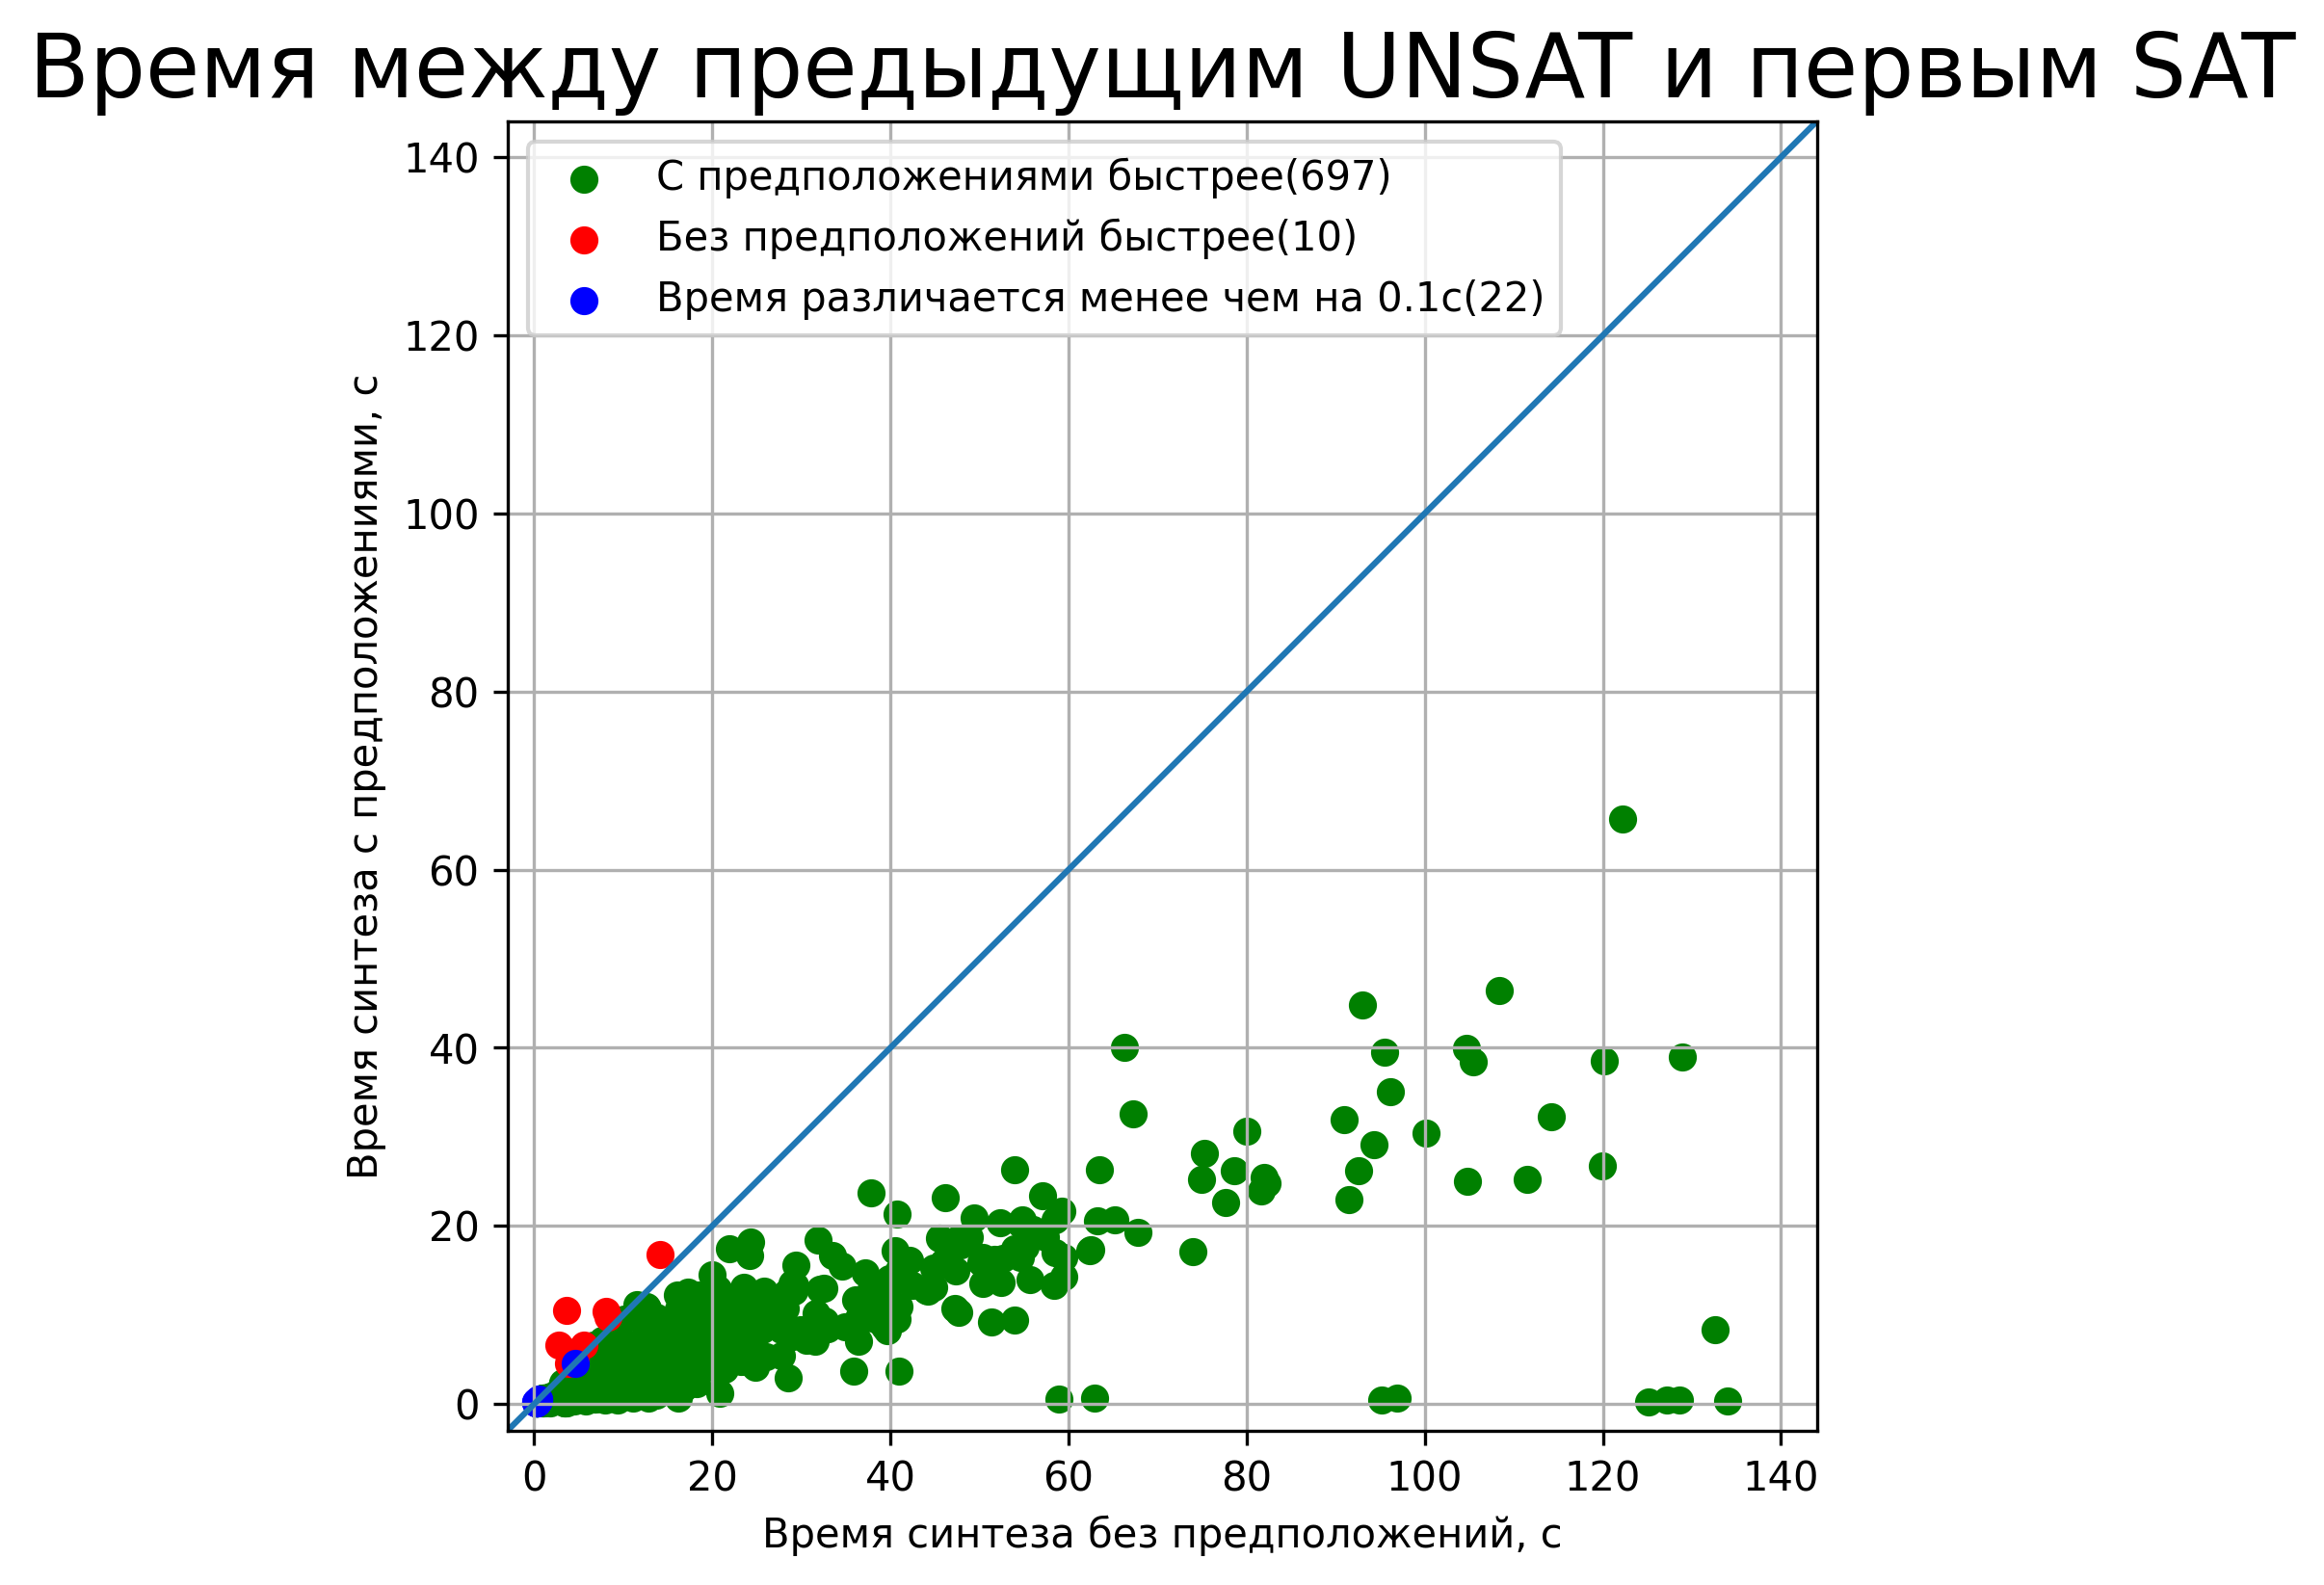

In [36]:
plt.figure(figsize=(8,6), dpi= 300)

info = extract_info(assumptions_stats, [(4, {'assumptions_between_loops_duration', 'general_between_loops_duration'})])
keys = list({k[:4] + k[5:] for k in info if k[:4] + ('assumptions_between_loops_duration',) + k[5:] in info and k[:4] + ('general_between_loops_duration',) + k[5:] in info})
y = [info[k[:4] + ('assumptions_between_loops_duration',) + k[4:]] for k in keys]
x = [info[k[:4] + ('general_between_loops_duration'    ,) + k[4:]] for k in keys]
x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones = split_coordinates(x, y, 0)
print_loop_csv('assumptions_loop', x_green, y_green, x_red, y_red, x_blue, y_blue, "С предположениями")

plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
plt.scatter(x_blue, y_blue, color='blue', label=f'Время различается менее чем на 0.1с({len(x_blue)})')
#plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
mx = max(max(x), max(y))
plt.plot([-3, mx + 10], [-3, mx + 10])
plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

plt.title('Время между предыдущим UNSAT и первым SAT', fontsize=22)
plt.xlabel('Время синтеза без предположений, с')
plt.ylabel('Время синтеза с предположениями, с')
plt.grid()
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

<ipython-input-37-44c30bac4a30>:15: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


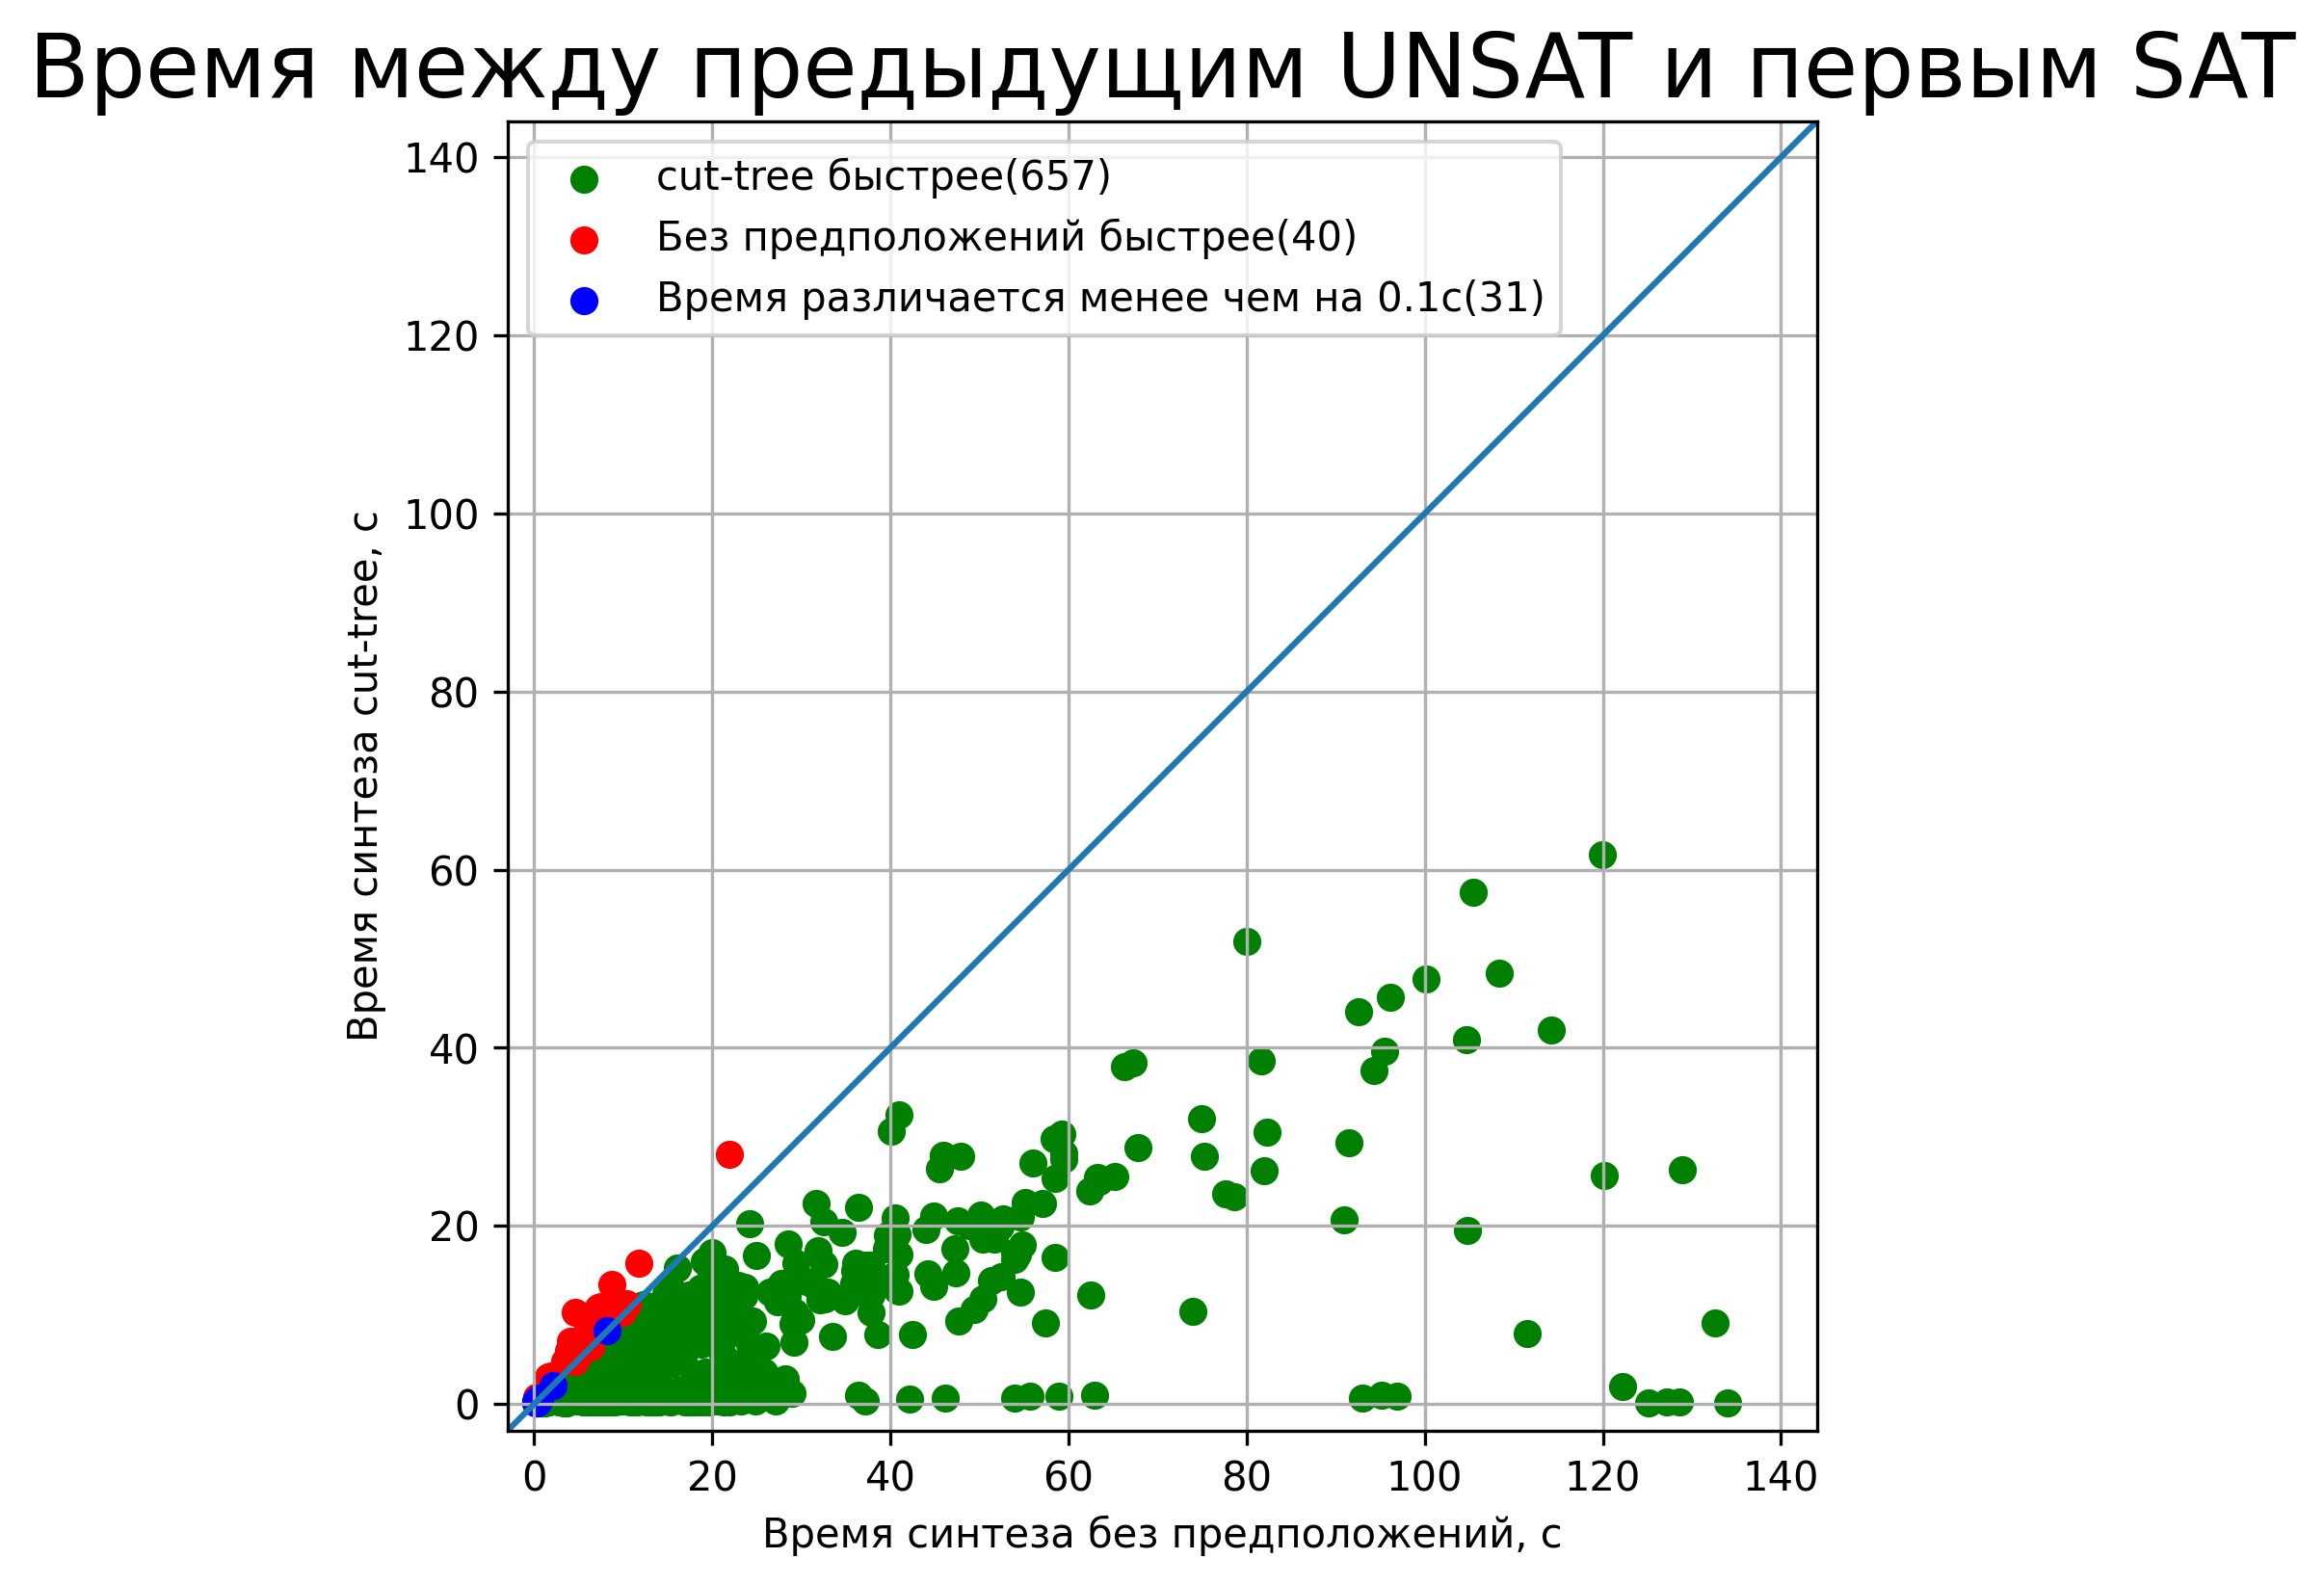

In [37]:
plt.figure(figsize=(8,6), dpi= 300)

info = extract_info(cut_tree_stats, [(4, {'cut_tree_between_loops_duration', 'general_between_loops_duration'})])
keys = list({k[:4] + k[5:] for k in info if k[:4] + ('cut_tree_between_loops_duration',) + k[5:] in info and k[:4] + ('general_between_loops_duration',) + k[5:] in info})
y = [info[k[:4] + ('cut_tree_between_loops_duration',) + k[4:]] for k in keys]
x = [info[k[:4] + ('general_between_loops_duration'    ,) + k[4:]] for k in keys]
x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones = split_coordinates(x, y, 0)

plt.scatter(x_green, y_green, color='green', label=f'cut-tree быстрее({len(x_green)})')
plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
plt.scatter(x_blue, y_blue, color='blue', label=f'Время различается менее чем на 0.1с({len(x_blue)})')
#plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
mx = max(max(x), max(y))
plt.plot([-3, mx + 10], [-3, mx + 10])
plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

plt.title('Время между предыдущим UNSAT и первым SAT', fontsize=22)
plt.xlabel('Время синтеза без предположений, с')
plt.ylabel('Время синтеза cut-tree, с')
plt.grid()
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

<ipython-input-38-346d4e02a63b>:15: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


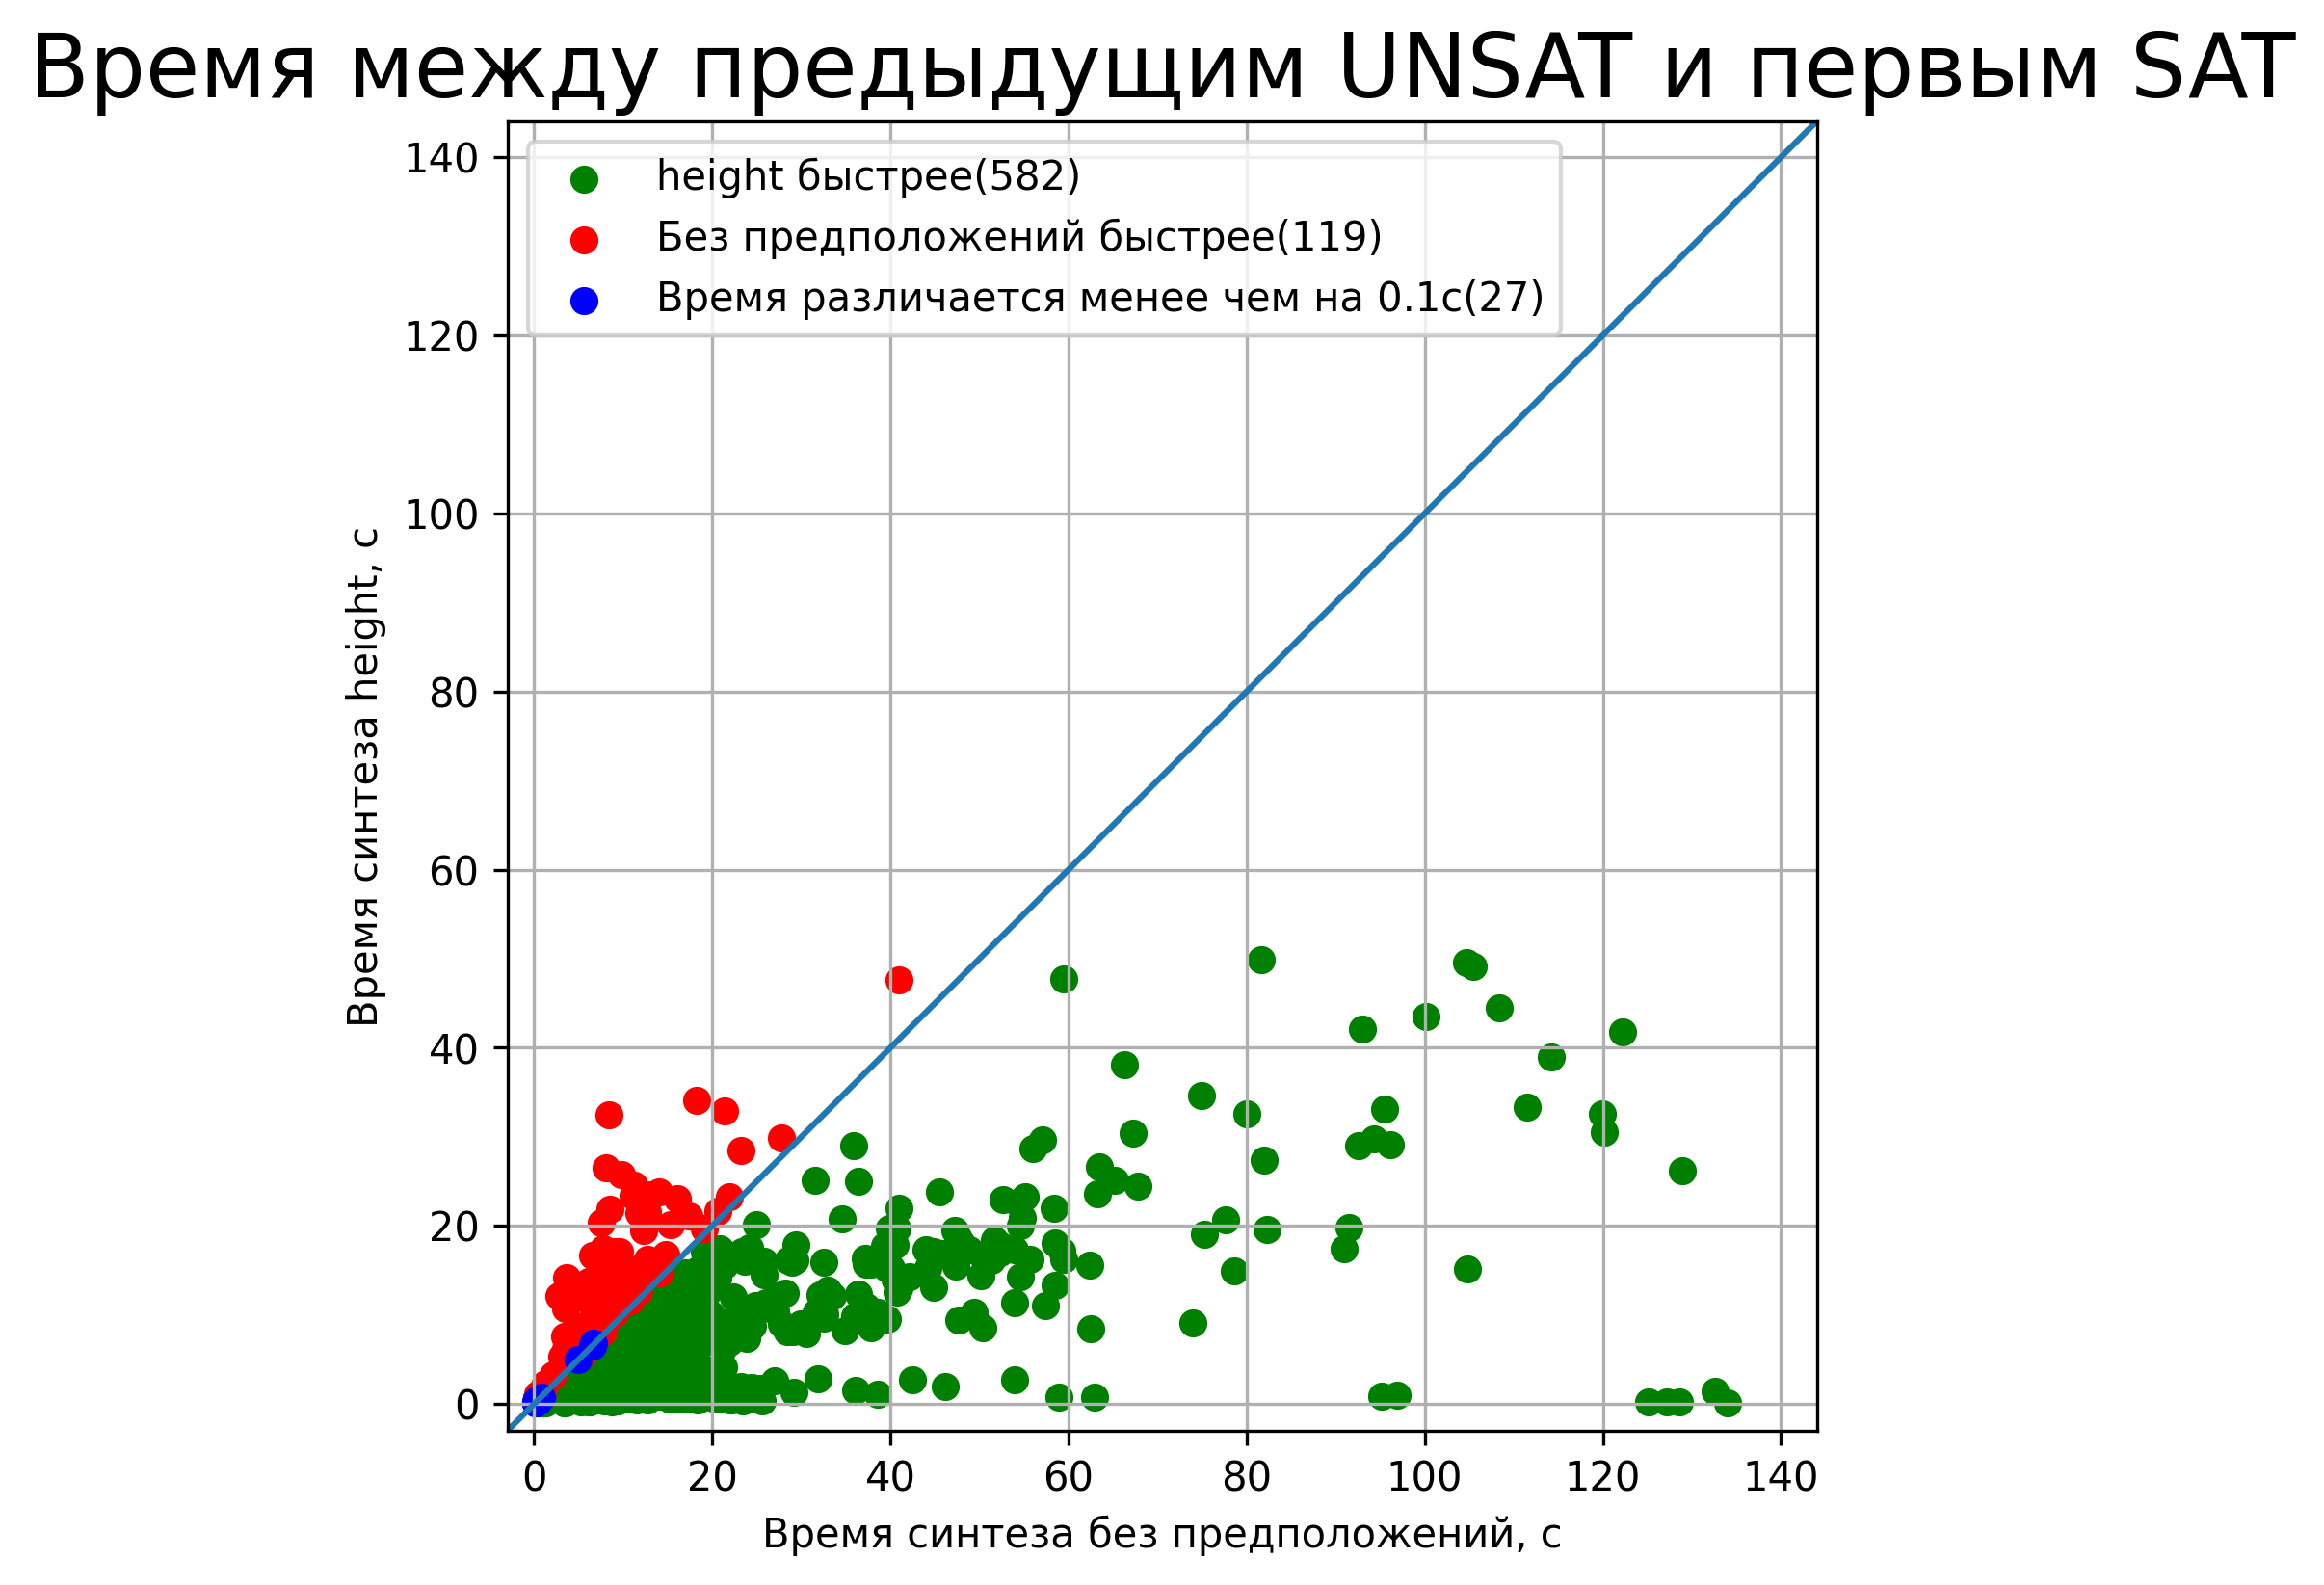

In [38]:
plt.figure(figsize=(8,6), dpi= 300)

info = extract_info(height_stats, [(4, {'height_between_loops_duration', 'general_between_loops_duration'})])
keys = list({k[:4] + k[5:] for k in info if k[:4] + ('height_between_loops_duration',) + k[5:] in info and k[:4] + ('general_between_loops_duration',) + k[5:] in info})
y = [info[k[:4] + ('height_between_loops_duration',) + k[4:]] for k in keys]
x = [info[k[:4] + ('general_between_loops_duration'    ,) + k[4:]] for k in keys]
x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones = split_coordinates(x, y, 0)

plt.scatter(x_green, y_green, color='green', label=f'height быстрее({len(x_green)})')
plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
plt.scatter(x_blue, y_blue, color='blue', label=f'Время различается менее чем на 0.1с({len(x_blue)})')
#plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
mx = max(max(x), max(y))
plt.plot([-3, mx + 10], [-3, mx + 10])
plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

plt.title('Время между предыдущим UNSAT и первым SAT', fontsize=22)
plt.xlabel('Время синтеза без предположений, с')
plt.ylabel('Время синтеза height, с')
plt.grid()
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

<ipython-input-6-59aaefccc077>:20: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


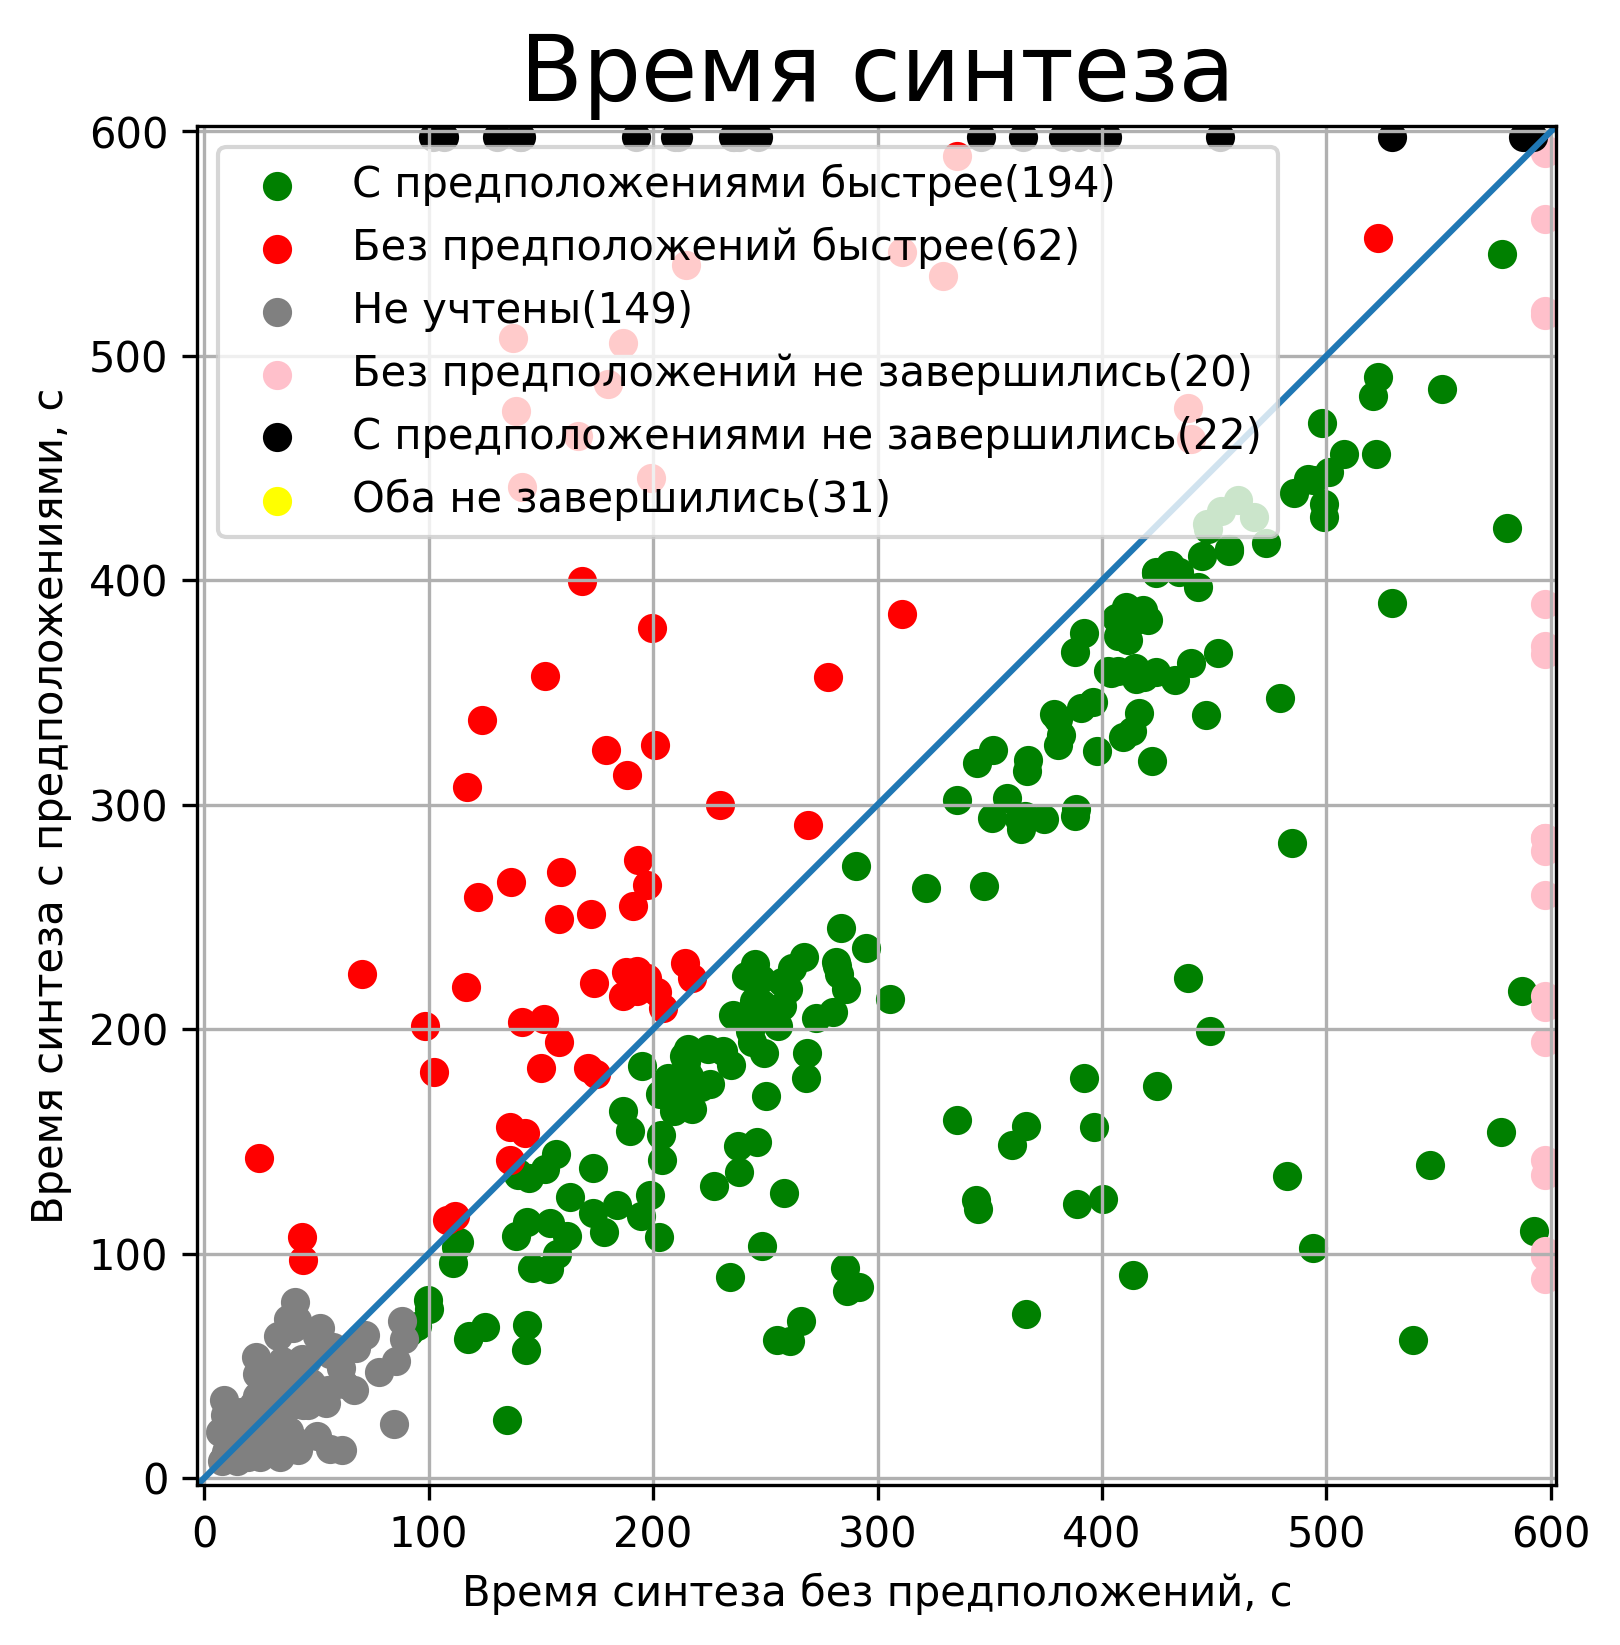

In [6]:
plt.figure(figsize=(8,6), dpi= 300)

info = extract_info(assumptions_stats, [(4, {'assumptions_total_duration', 'general_total_duration'})])
#keys = list({k[:4] for k in info if info[k[:4] + ('assumptions_total_duration',)] is not None and info[k[:4] + ('general_total_duration',)] is not None})
keys = list({k[:4] for k in info})
y = [info[k[:4] + ('assumptions_total_duration',)] for k in keys]
x = [info[k[:4] + ('general_total_duration'    ,)] for k in keys]
x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones = split_coordinates(x, y)
mx = max(x_green + y_green + x_red + y_red + x_blue + y_blue + x_gray + y_gray)
print_csv('assumptions', x_green, y_green, x_red, y_red, x_gray, y_gray, y_xnone, x_ynone, nones, "С предположениями")

plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
#plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
plt.scatter([mx + 5] * len(y_xnone), y_xnone, color='pink', label=f'Без предположений не завершились({len(y_xnone)})')
plt.scatter(x_ynone, [mx + 5] * len(x_ynone), color='black', label=f'С предположениями не завершились({len(x_ynone)})')
plt.scatter([], [], color='yellow', label=f'Оба не завершились({nones})')
plt.plot([-3, mx + 10], [-3, mx + 10])
plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

plt.title('Время синтеза', fontsize=22)
plt.xlabel('Время синтеза без предположений, с')
plt.ylabel('Время синтеза с предположениями, с')
plt.grid()
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

<ipython-input-18-05ce22ea745a>:19: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


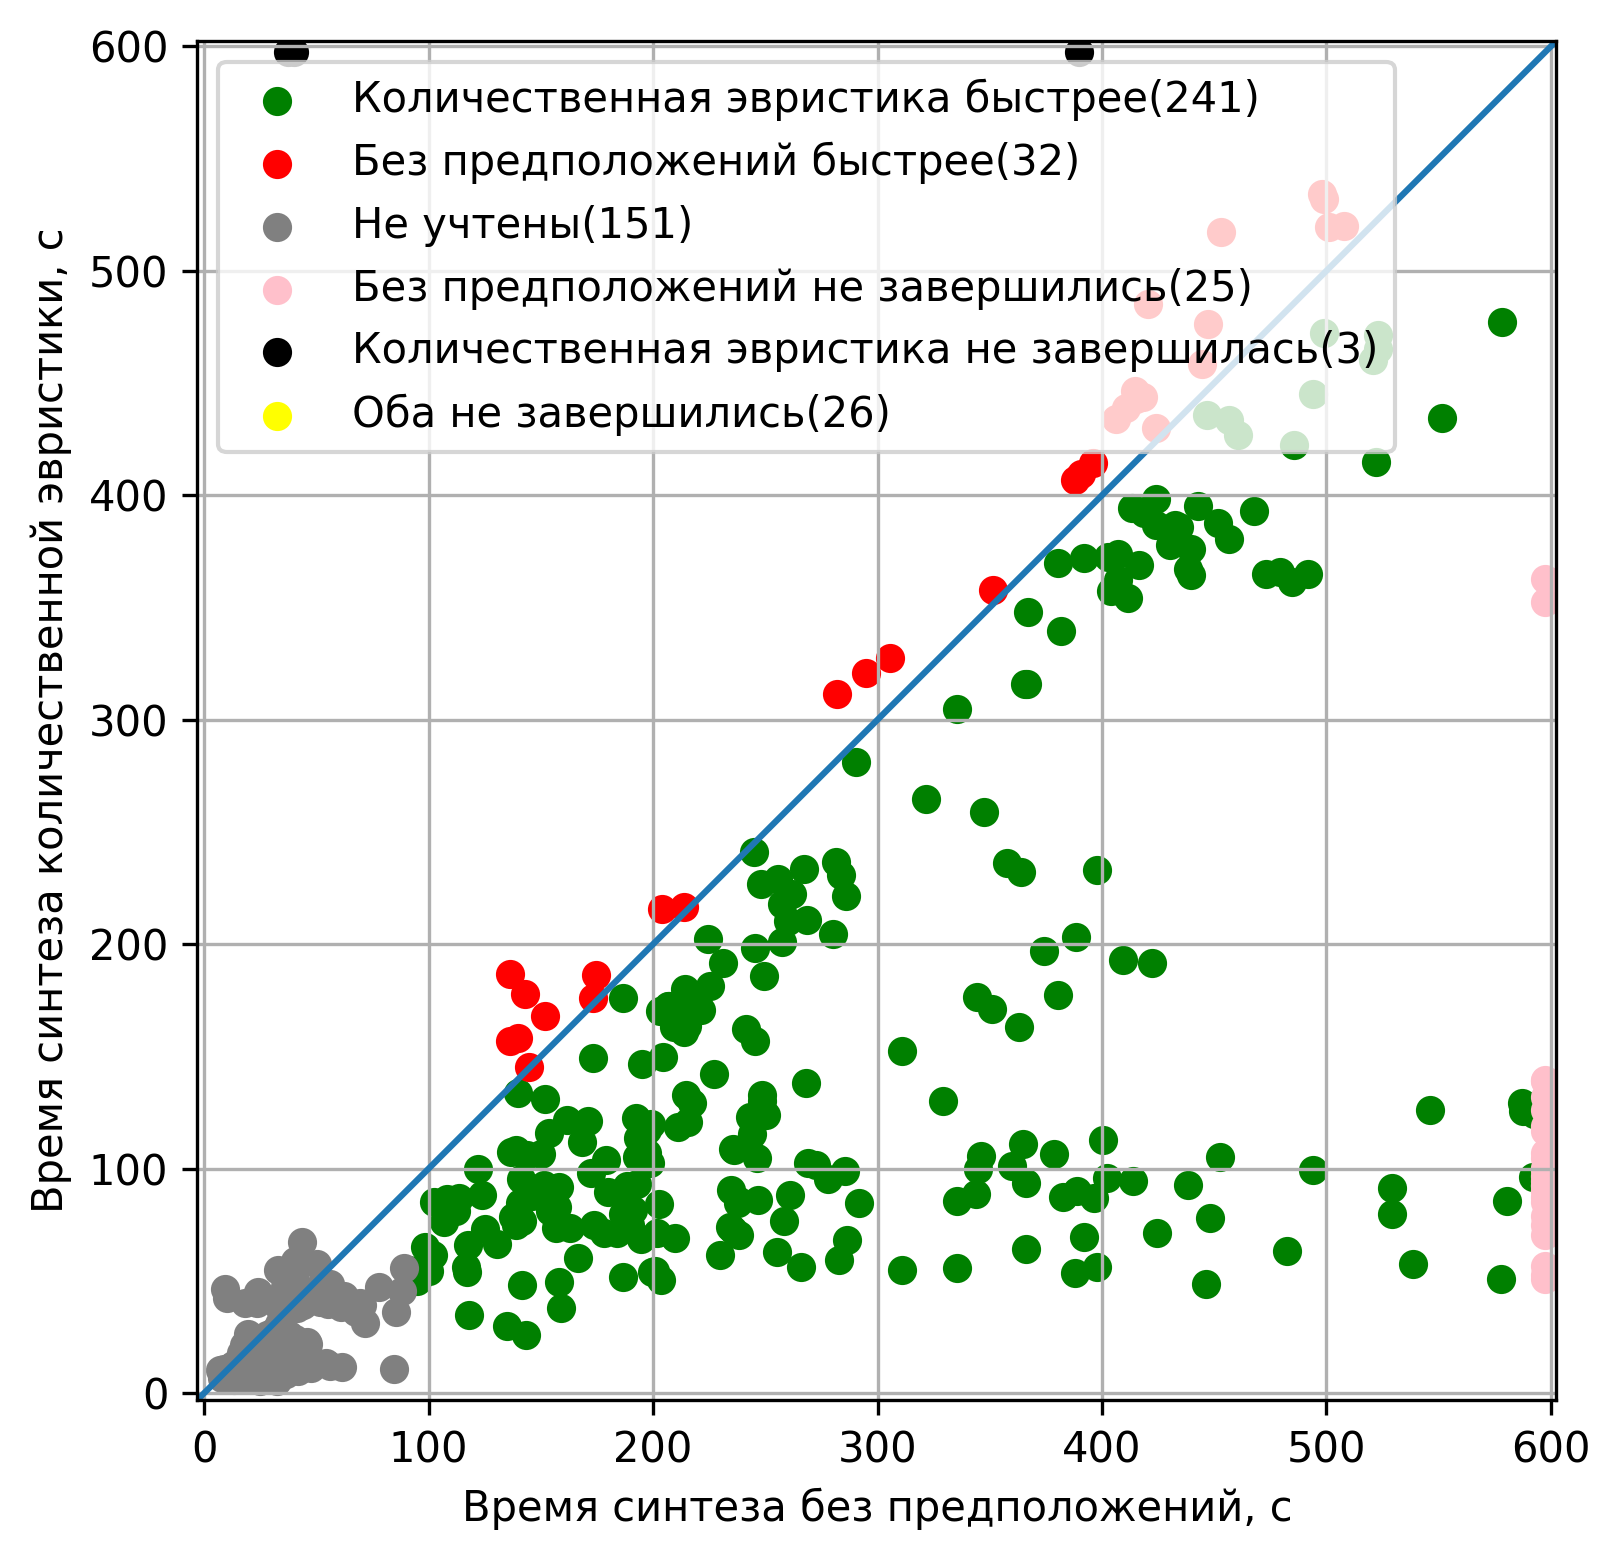

In [18]:
plt.figure(figsize=(8,6), dpi= 300)

info = extract_info(cut_tree_stats, [(4, {'cut_tree_total_duration', 'general_total_duration'})])
keys = list({k[:4] for k in info})
y = [info[k[:4] + ('cut_tree_total_duration',)] for k in keys]
x = [info[k[:4] + ('general_total_duration' ,)] for k in keys]
x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones = split_coordinates(x, y)
mx = max(x_green + y_green + x_red + y_red + x_blue + y_blue + x_gray + y_gray)
print_csv('count', x_green, y_green, x_red, y_red, x_gray, y_gray, y_xnone, x_ynone, nones, "Эвристика 1")

plt.scatter(x_green, y_green, color='green', label=f'Количественная эвристика быстрее({len(x_green)})')
plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
#plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
plt.scatter([mx + 5] * len(y_xnone), y_xnone, color='pink', label=f'Без предположений не завершились({len(y_xnone)})')
plt.scatter(x_ynone, [mx + 5] * len(x_ynone), color='black', label=f'Количественная эвристика не завершилась({len(x_ynone)})')
plt.scatter([], [], color='yellow', label=f'Оба не завершились({nones})')
plt.plot([-3, mx + 10], [-3, mx + 10])
plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

#plt.title('Время синтеза', fontsize=22)
plt.xlabel('Время синтеза без предположений, с')
plt.ylabel('Время синтеза количественной эвристики, с')
plt.grid()
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

<ipython-input-19-b6d4eae48128>:19: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


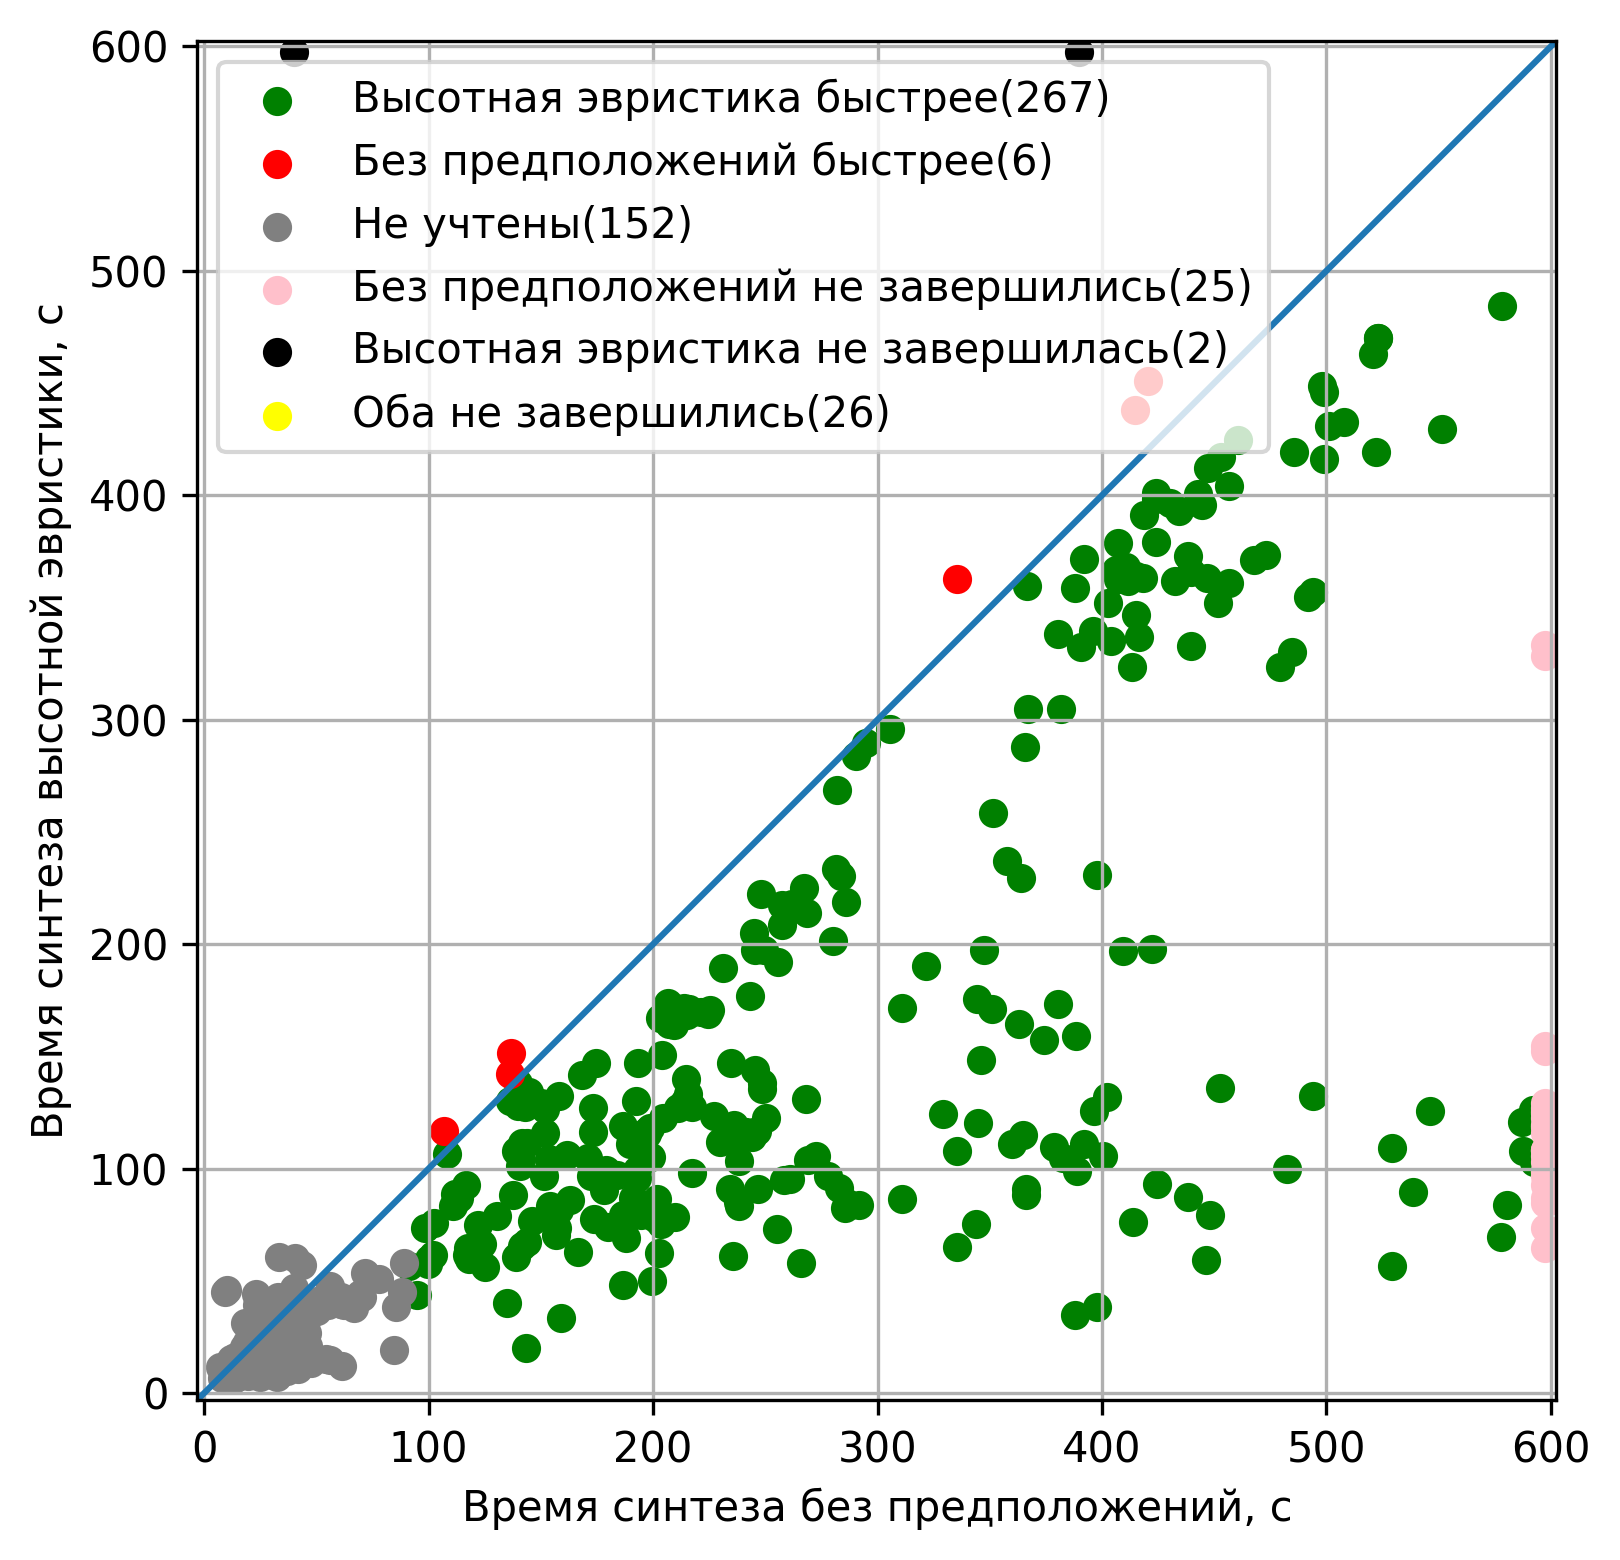

In [19]:
plt.figure(figsize=(8,6), dpi= 300)

info = extract_info(height_stats, [(4, {'height_total_duration', 'general_total_duration'})])
keys = list({k[:4] for k in info})
y = [info[k[:4] + ('height_total_duration' ,)] for k in keys]
x = [info[k[:4] + ('general_total_duration',)] for k in keys]
x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones = split_coordinates(x, y)
mx = max(x_green + y_green + x_red + y_red + x_blue + y_blue + x_gray + y_gray)
print_csv('height', x_green, y_green, x_red, y_red, x_gray, y_gray, y_xnone, x_ynone, nones, "Эвристика 2")

plt.scatter(x_green, y_green, color='green', label=f'Высотная эвристика быстрее({len(x_green)})')
plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
#plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
plt.scatter([mx + 5] * len(y_xnone), y_xnone, color='pink', label=f'Без предположений не завершились({len(y_xnone)})')
plt.scatter(x_ynone, [mx + 5] * len(x_ynone), color='black', label=f'Высотная эвристика не завершилась({len(x_ynone)})')
plt.scatter([], [], color='yellow', label=f'Оба не завершились({nones})')
plt.plot([-3, mx + 10], [-3, mx + 10])
plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

#plt.title('Время синтеза', fontsize=22)
plt.xlabel('Время синтеза без предположений, с')
plt.ylabel('Время синтеза высотной эвристики, с')
plt.grid()
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

In [42]:
for i in range(1, 100):
    continue
    
    plt.figure(figsize=(8,6), dpi=300)

    info = extract_info(assumptions_stats, [(4, {'assumptions_between_loops_duration', 'general_between_loops_duration'}), (5, {i})])
    if len(info) == 0:
        break
    keys = list({k[:4] + k[5:] for k in info if k[:4] + ('assumptions_between_loops_duration',) + k[5:] in info and k[:4] + ('general_between_loops_duration',) + k[5:] in info})
    y = [info[k[:4] + ('assumptions_between_loops_duration',) + k[4:]] for k in keys]
    x = [info[k[:4] + ('general_between_loops_duration'    ,) + k[4:]] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray = split_coordinates(x, y, 0)
    
    plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
    #plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    mx = max(max(x), max(y))
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')
    
    plt.title(f'durations-between-loops on iteration-number={i}', fontsize=22)
    plt.xlabel('Время синтеза без предположений, с')
    plt.ylabel('Время синтеза с предположениями, с')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()

In [43]:
for i in range(18, 21):
    continue
    
    plt.figure(figsize=(8,6), dpi=300)
    info = extract_info(assumptions_stats, [(1, {i}), (4, {'assumptions_between_loops_duration', 'general_between_loops_duration'})])
    keys = list({k[:4] + k[5:] for k in info if k[:4] + ('assumptions_between_loops_duration',) + k[5:] in info and k[:4] + ('general_between_loops_duration',) + k[5:] in info})
    y = [info[k[:4] + ('assumptions_between_loops_duration',) + k[4:]] for k in keys]
    x = [info[k[:4] + ('general_between_loops_duration'    ,) + k[4:]] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray = split_coordinates(x, y, 0)
    
    plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    plt.scatter(x_blue, y_blue, color='blue', label=f'Время различается менее чем на 0.1с({len(x_blue)})')
    #plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    mx = max(max(x), max(y))
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')
    
    plt.title(f'durations-between-loops on trace-length={i}', fontsize=22)
    plt.xlabel('сек. без предположений')
    plt.ylabel('сек. с предположениями')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()


<ipython-input-15-f46cc29753cb>:20: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


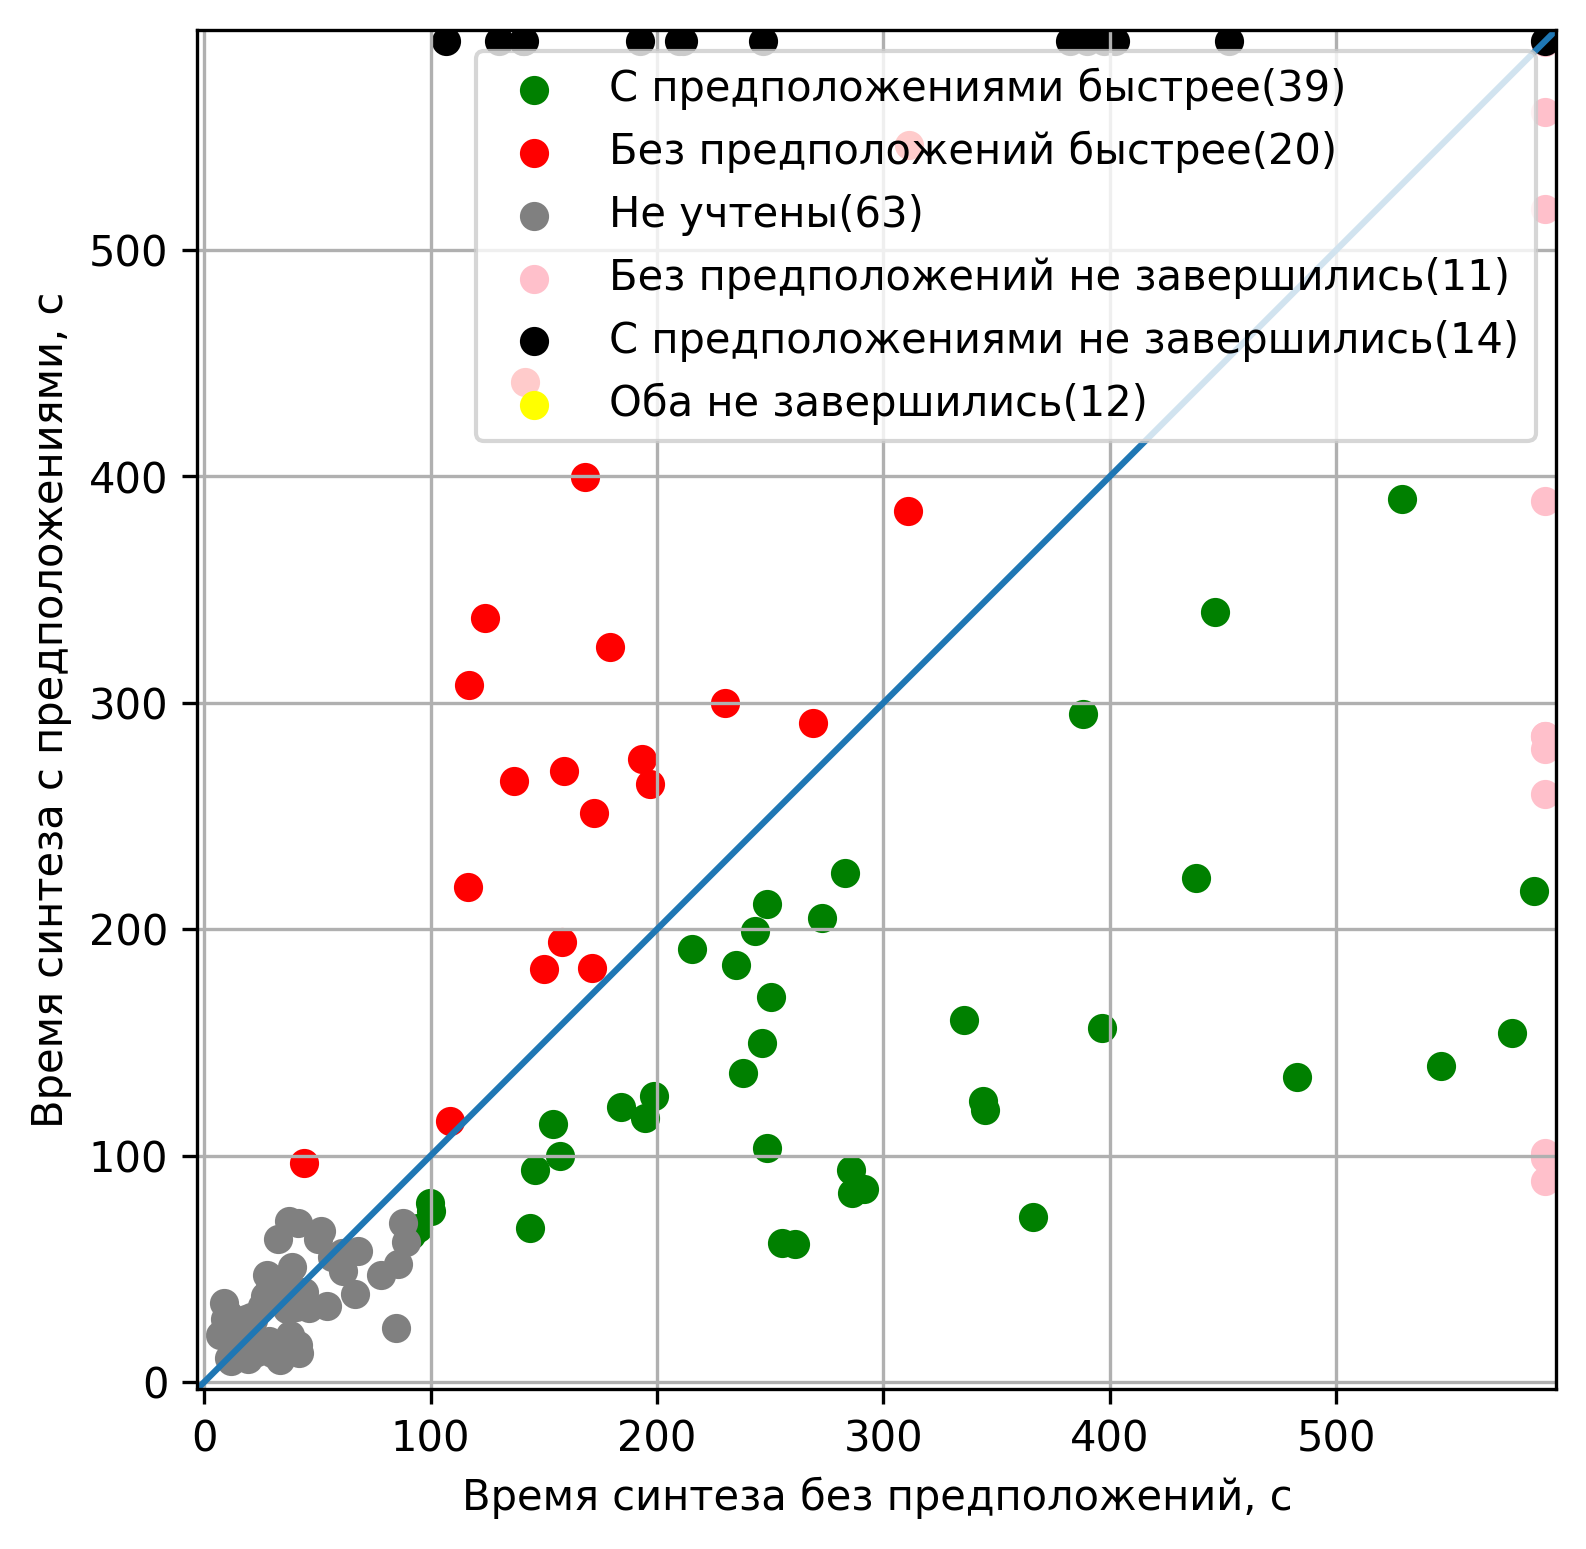

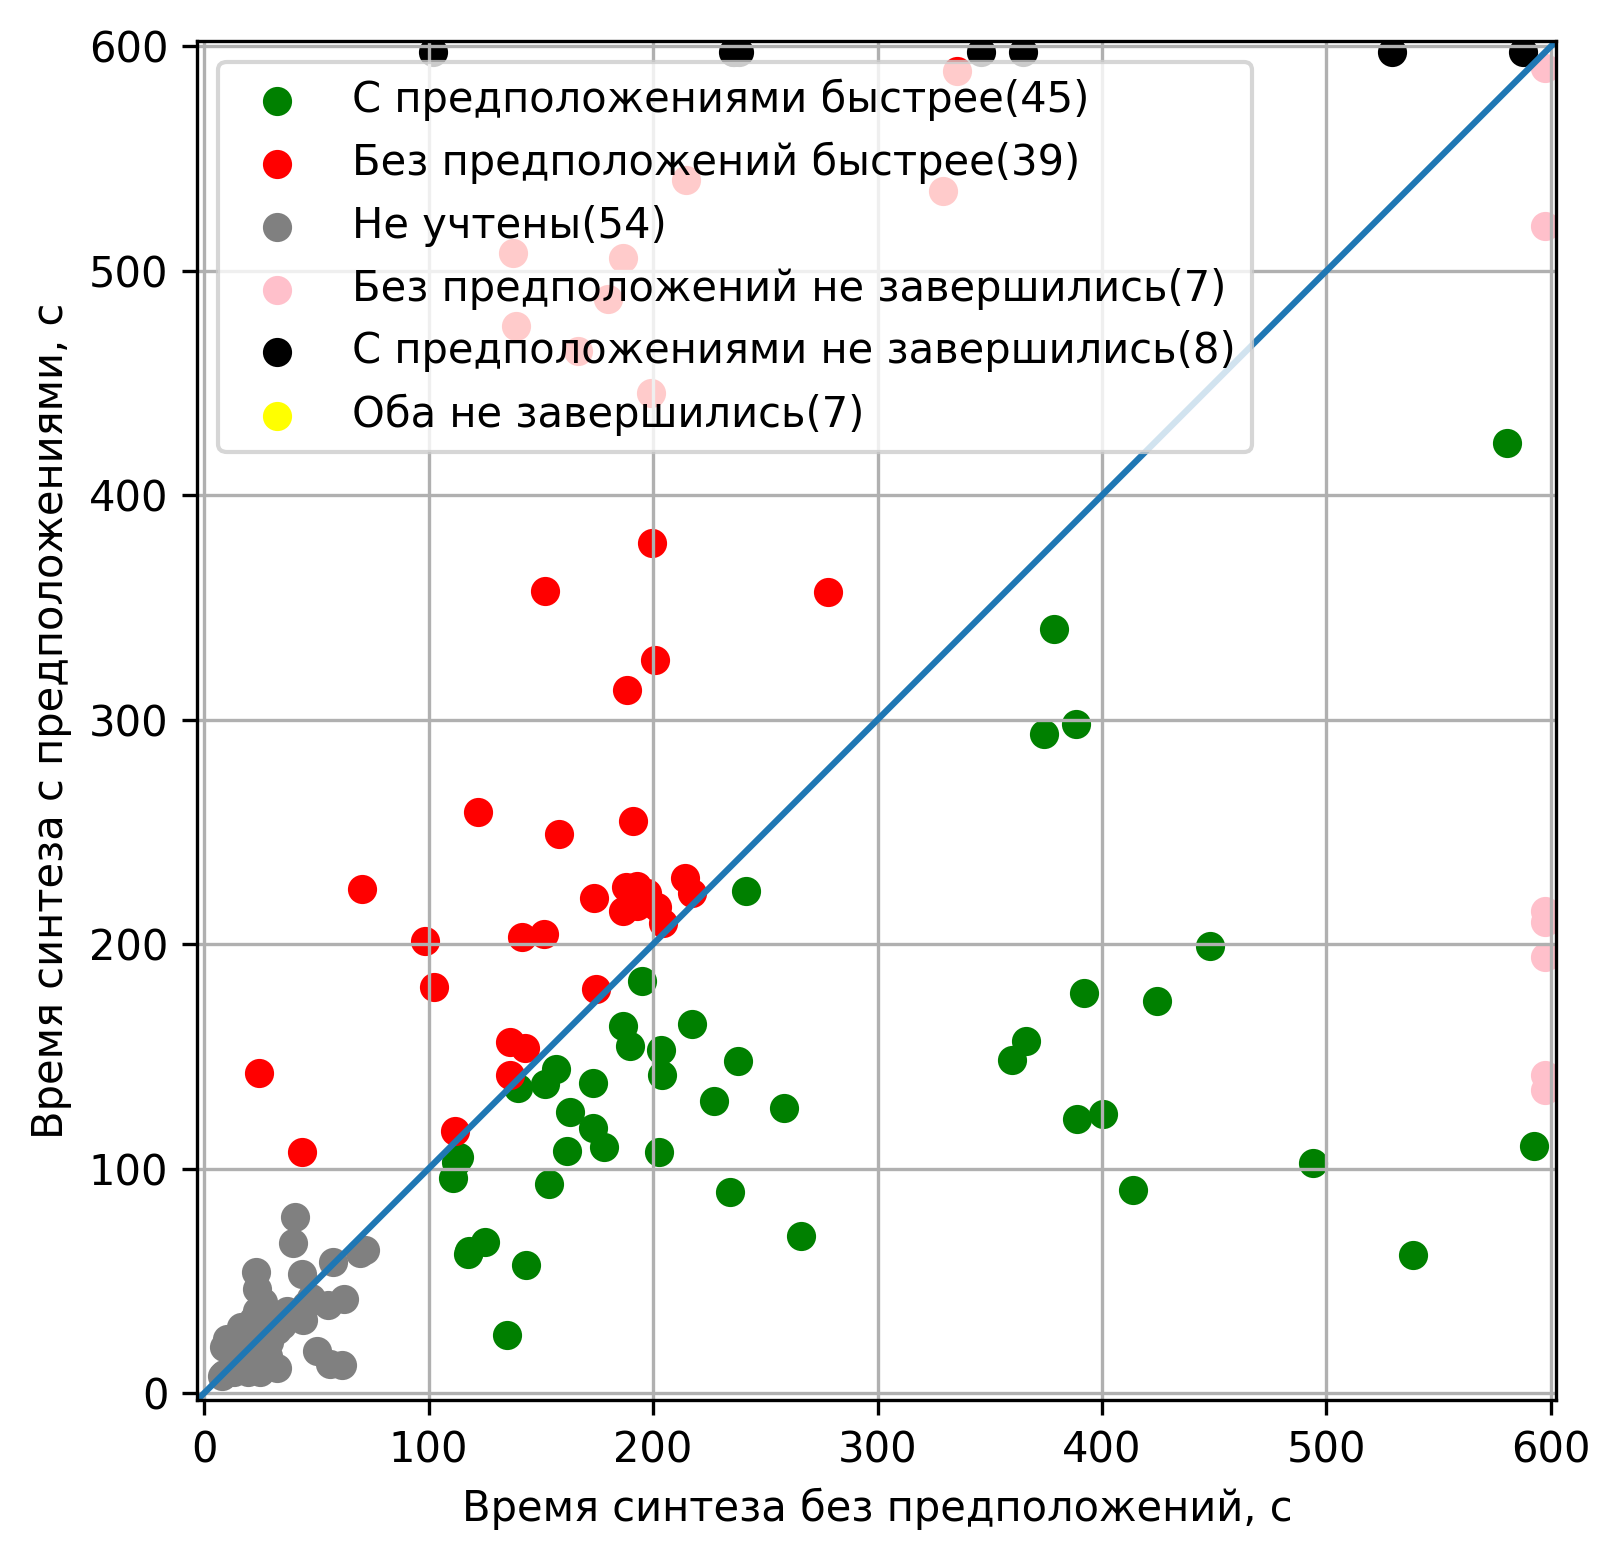

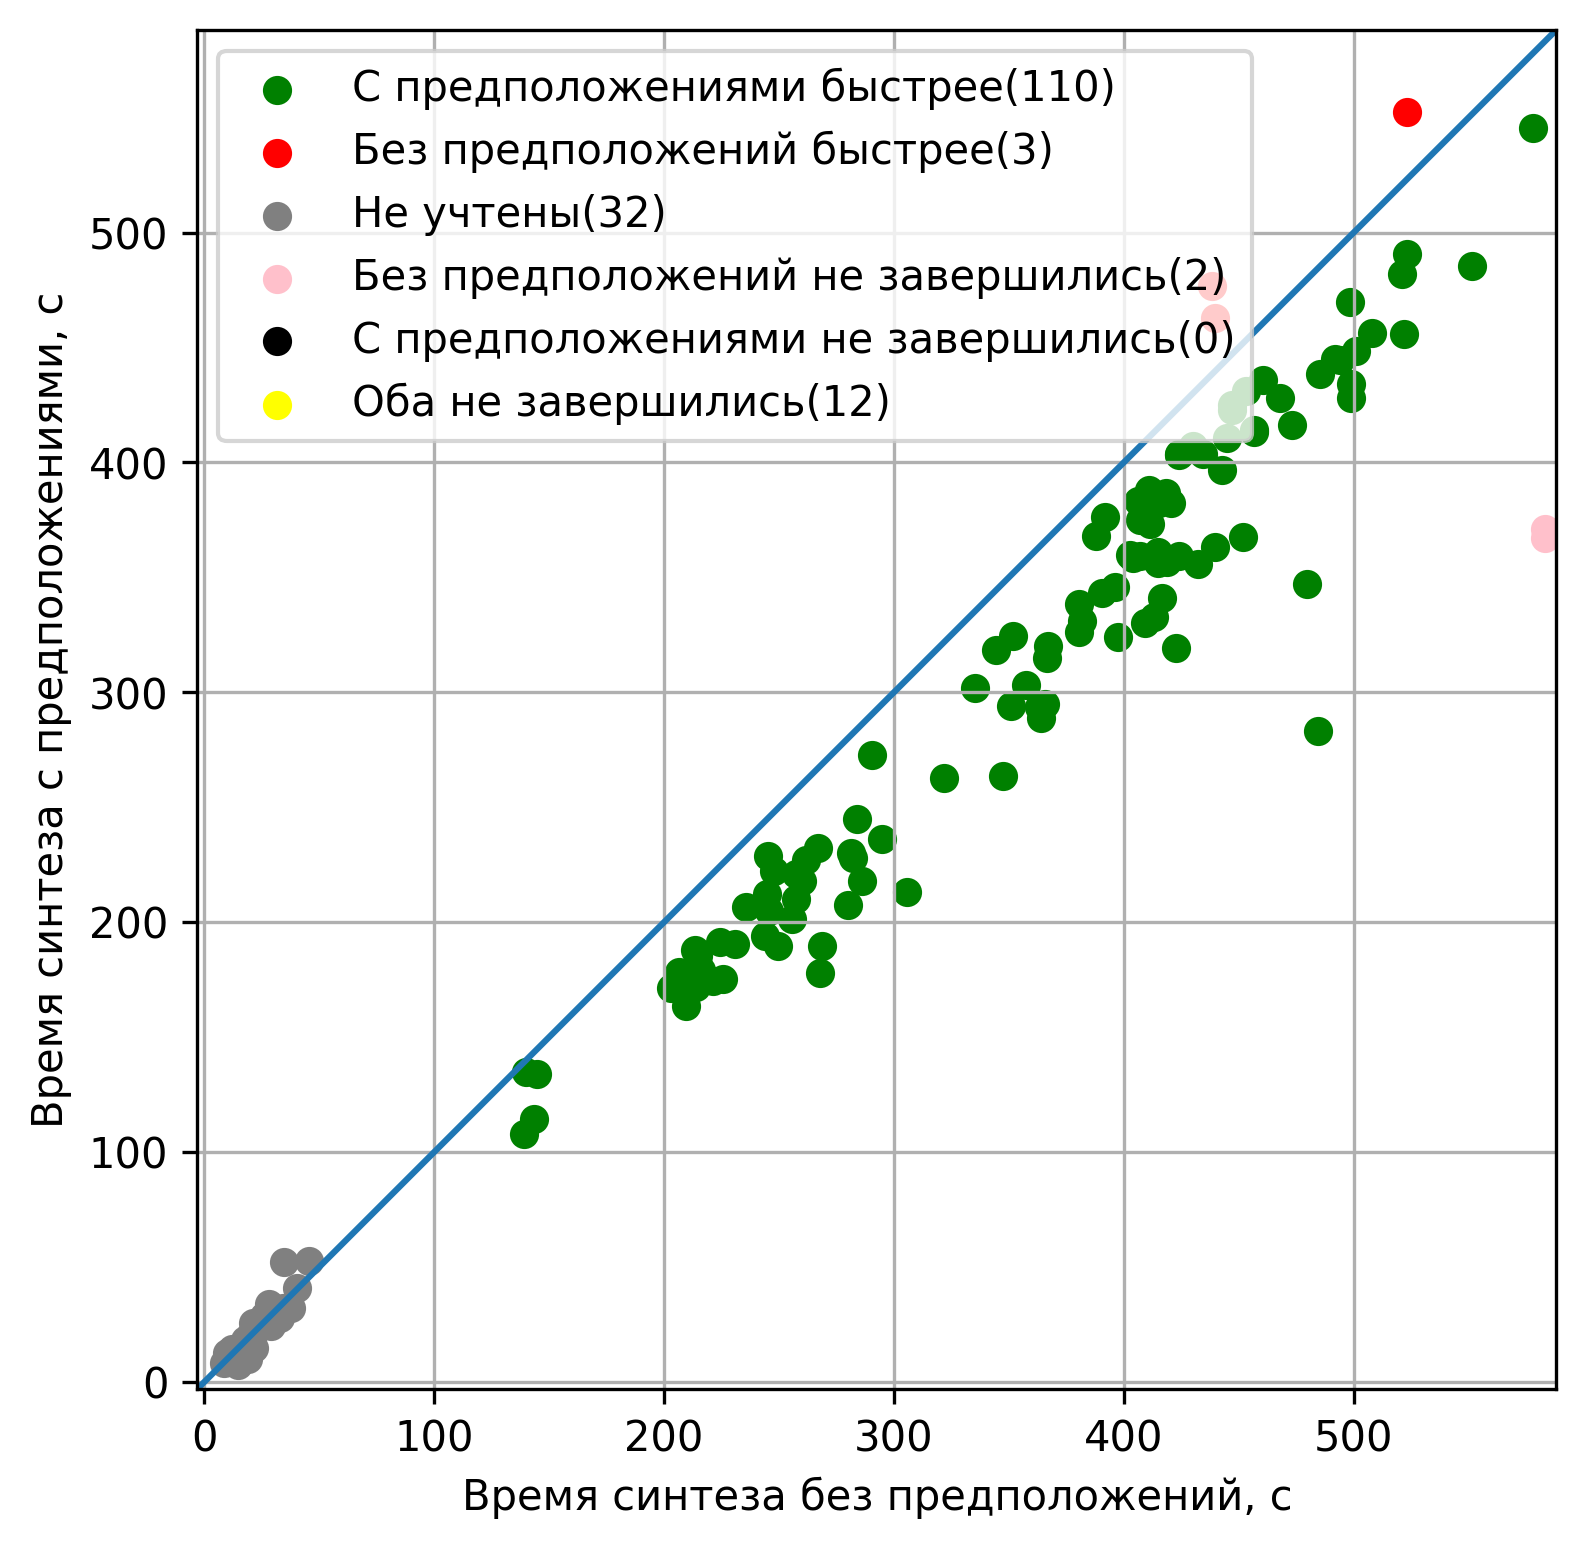

In [15]:
for i in range(18, 21):
    plt.figure(figsize=(8,6), dpi= 300)

    info = extract_info(assumptions_stats, [(1, {i}), (4, {'assumptions_total_duration', 'general_total_duration'})])
    keys = list({k[:4] for k in info})
    y = [info[k[:4] + ('assumptions_total_duration',)] for k in keys]
    x = [info[k[:4] + ('general_total_duration'    ,)] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones = split_coordinates(x, y)
    mx = max(x_green + y_green + x_red + y_red + x_blue + y_blue + x_gray + y_gray)
    print_csv(f'assumptions-{i}', x_green, y_green, x_red, y_red, x_gray, y_gray, y_xnone, x_ynone, nones, "С предположениями")

    plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    #plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
    plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    plt.scatter([mx + 5] * len(y_xnone), y_xnone, color='pink', label=f'Без предположений не завершились({len(y_xnone)})')
    plt.scatter(x_ynone, [mx + 5] * len(x_ynone), color='black', label=f'С предположениями не завершились({len(x_ynone)})')
    plt.scatter([], [], color='yellow', label=f'Оба не завершились({nones})')
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

    #plt.title(f'Время синтеза с длиной трассировки {i}', fontsize=20)
    plt.xlabel('Время синтеза без предположений, с')
    plt.ylabel('Время синтеза с предположениями, с')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()

<ipython-input-16-b70260967e97>:20: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


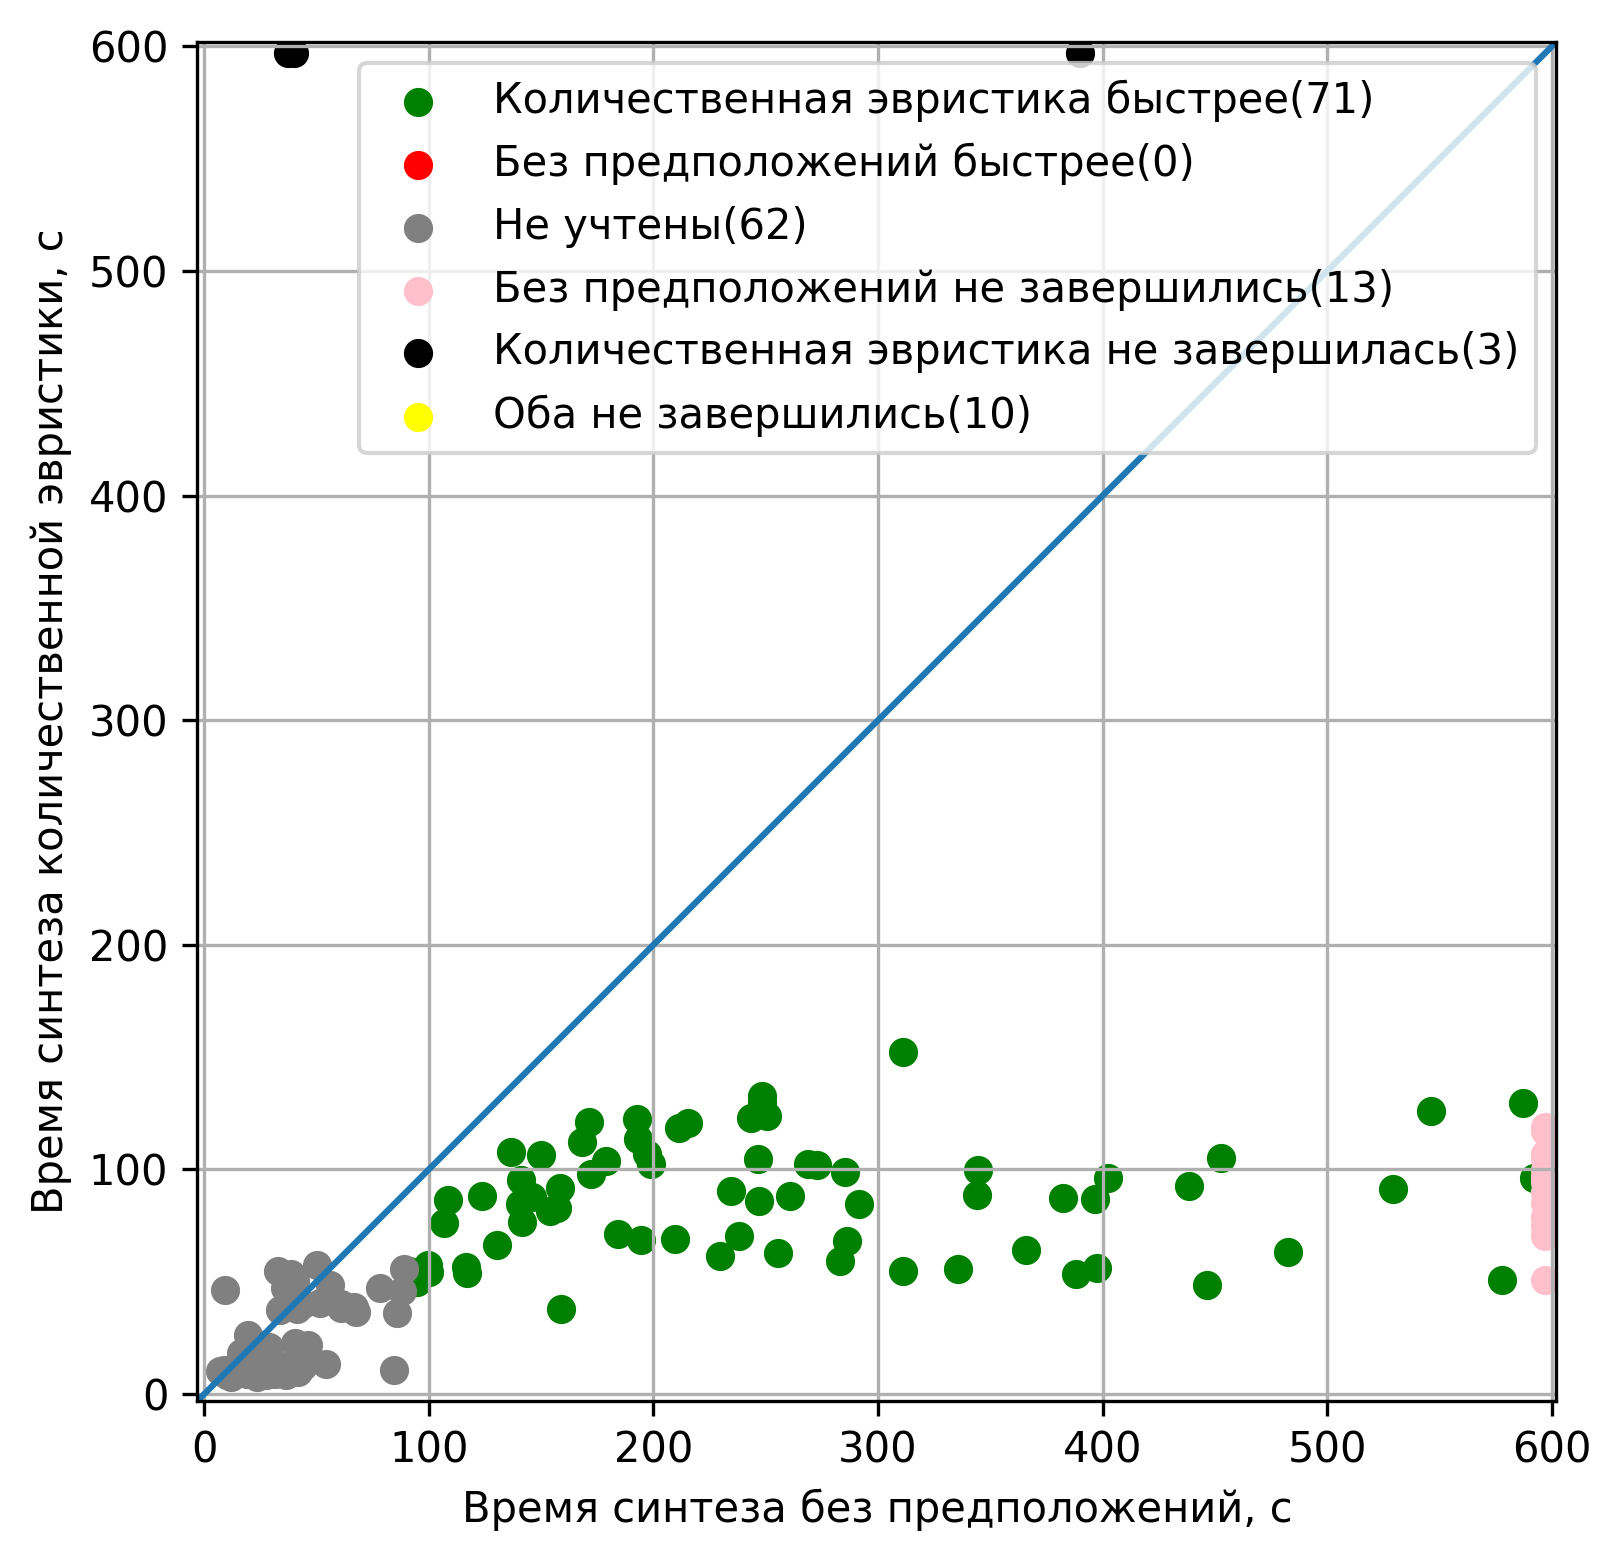

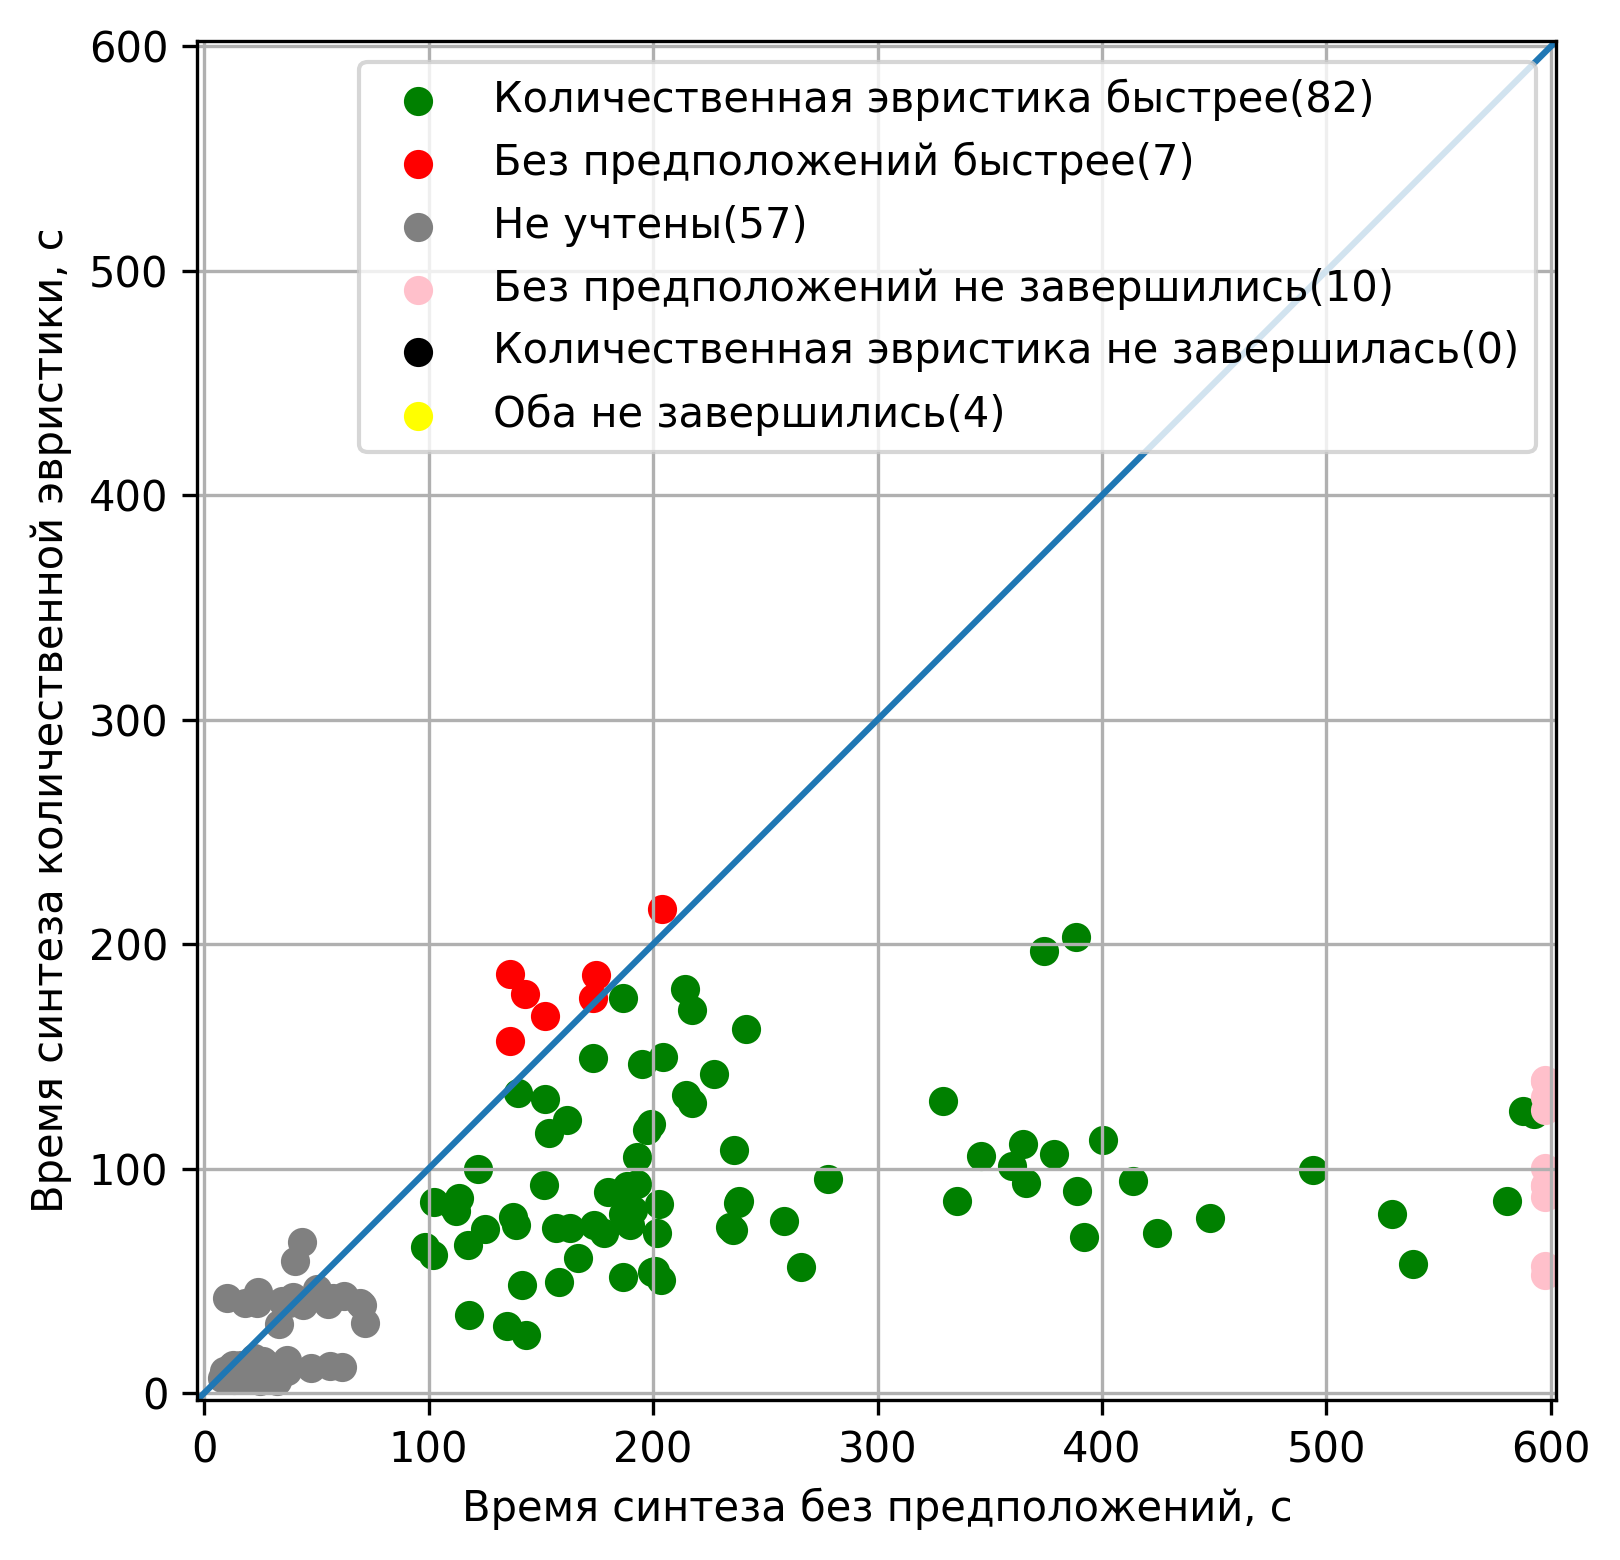

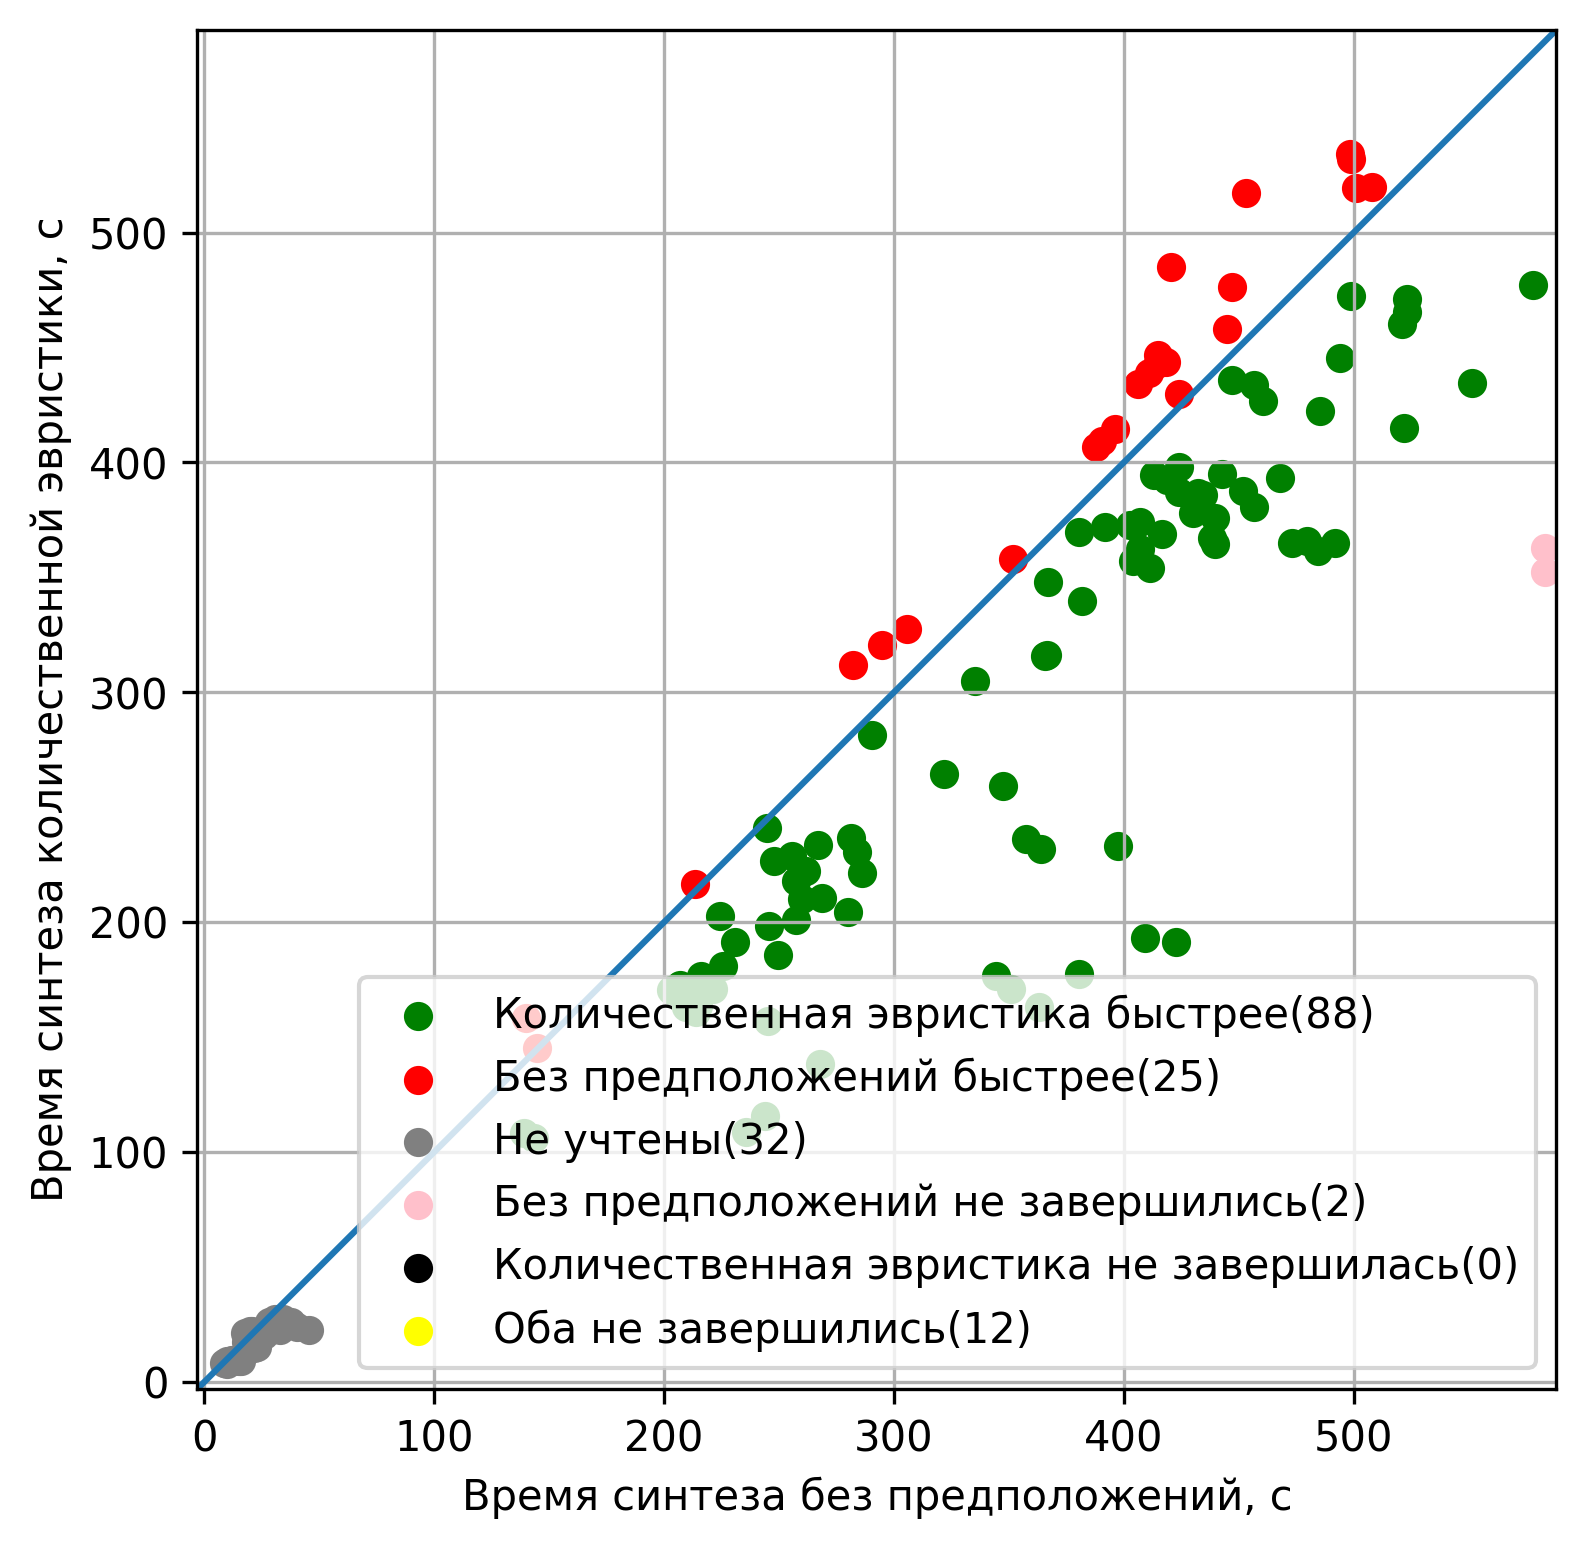

In [16]:
for i in range(18, 21):
    plt.figure(figsize=(8,6), dpi= 300)

    info = extract_info(cut_tree_stats, [(1, {i}), (4, {'cut_tree_total_duration', 'general_total_duration'})])
    keys = list({k[:4] for k in info})
    y = [info[k[:4] + ('cut_tree_total_duration',)] for k in keys]
    x = [info[k[:4] + ('general_total_duration'    ,)] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones = split_coordinates(x, y)
    mx = max(x_green + y_green + x_red + y_red + x_blue + y_blue + x_gray + y_gray)
    print_csv(f'count-{i}', x_green, y_green, x_red, y_red, x_gray, y_gray, y_xnone, x_ynone, nones, "Эвристика 1")

    plt.scatter(x_green, y_green, color='green', label=f'Количественная эвристика быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    #plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
    plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    plt.scatter([mx + 5] * len(y_xnone), y_xnone, color='pink', label=f'Без предположений не завершились({len(y_xnone)})')
    plt.scatter(x_ynone, [mx + 5] * len(x_ynone), color='black', label=f'Количественная эвристика не завершилась({len(x_ynone)})')
    plt.scatter([], [], color='yellow', label=f'Оба не завершились({nones})')
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

    #plt.title(f'Время синтеза с длиной трассировки {i}', fontsize=20)
    plt.xlabel('Время синтеза без предположений, с')
    plt.ylabel('Время синтеза количественной эвристики, с')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()

<ipython-input-17-e7e7b1a15f7d>:20: MatplotlibDeprecationWarning: Passing more than one positional argument to axis() is deprecated and will raise a TypeError two minor releases later.
  plt.axis([-3, mx + 10, -3, mx + 10], 'equal')


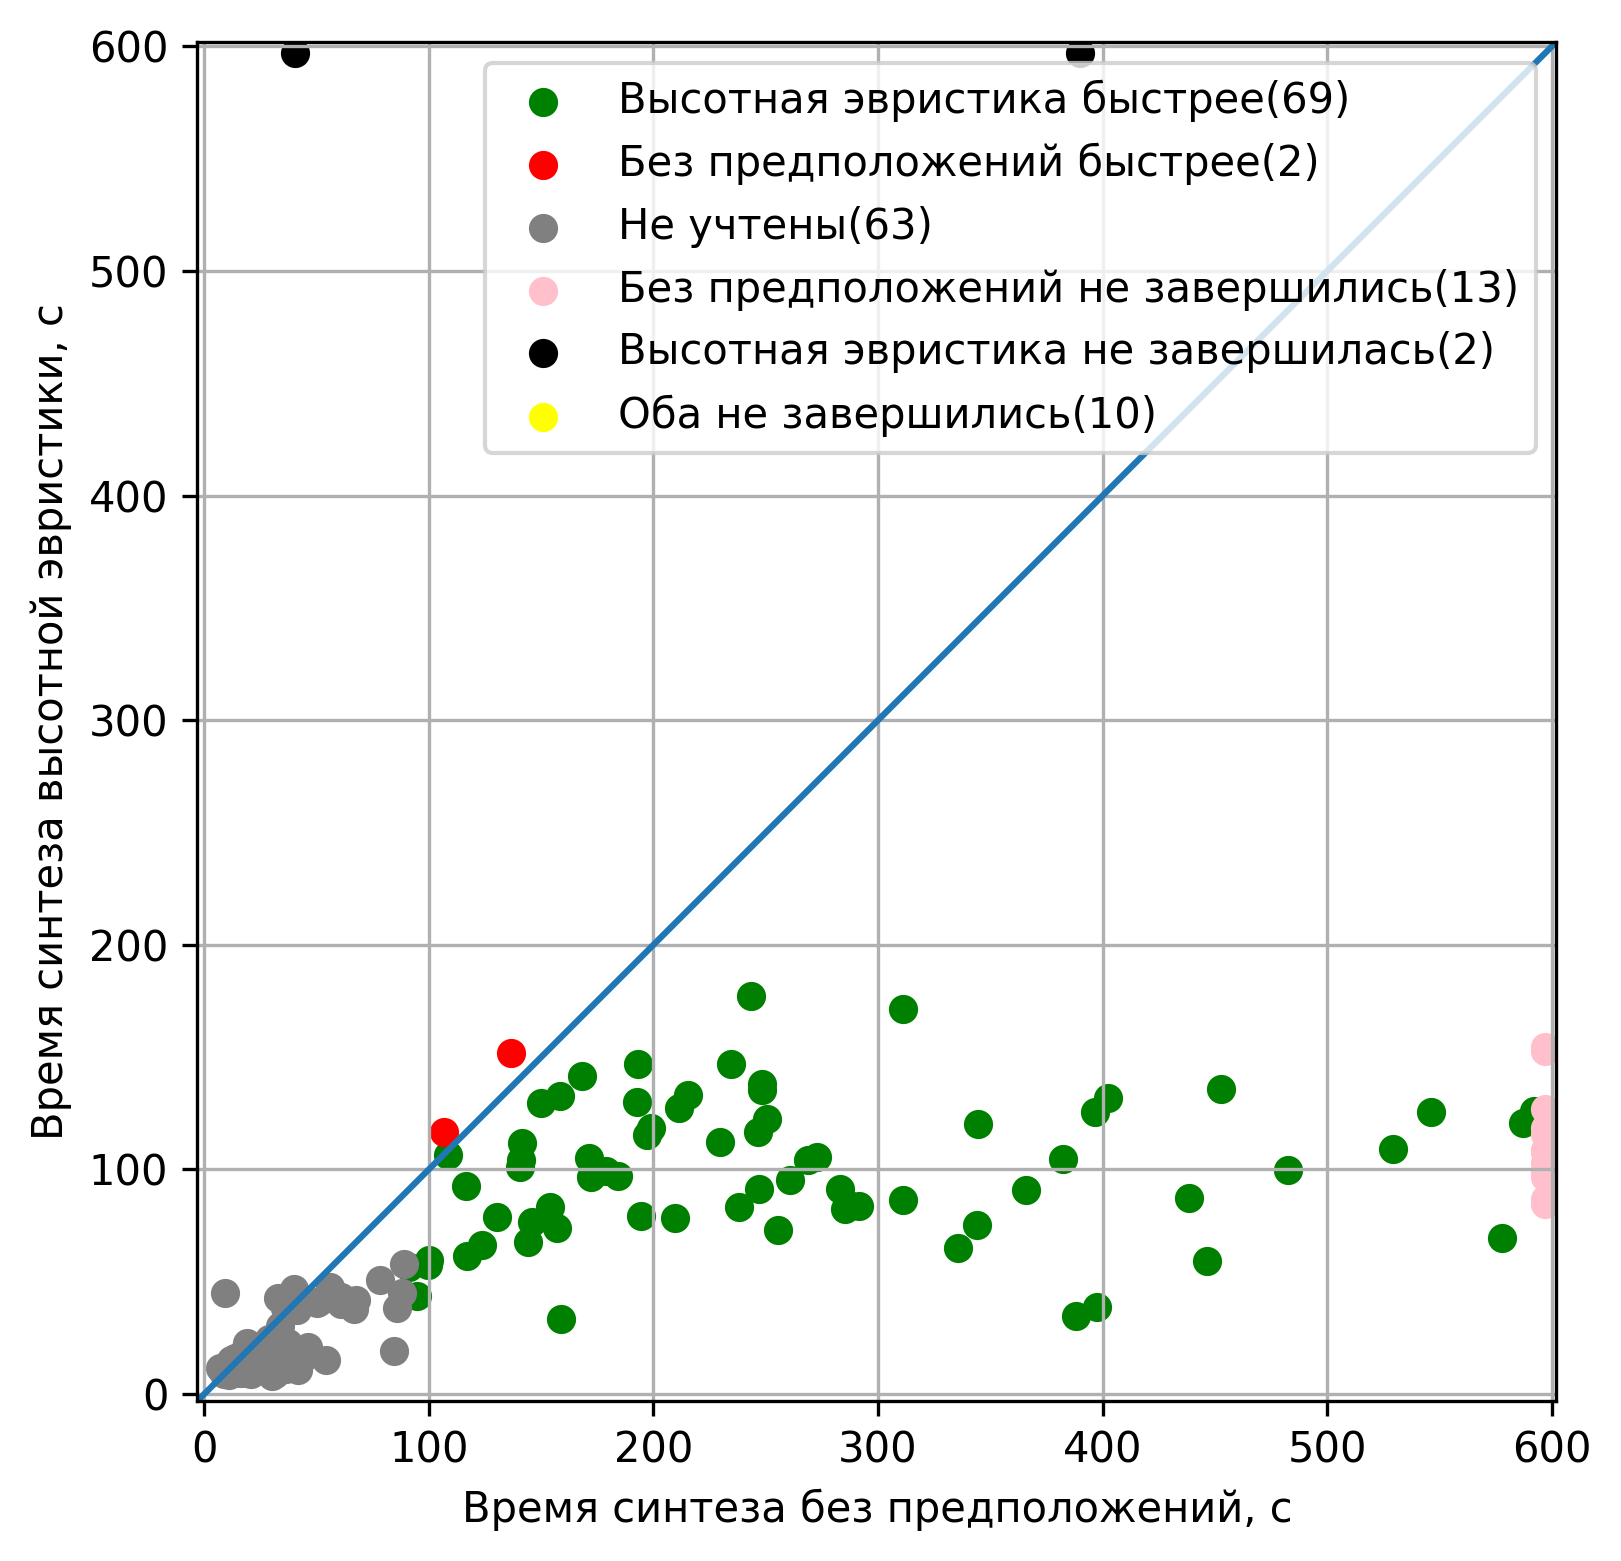

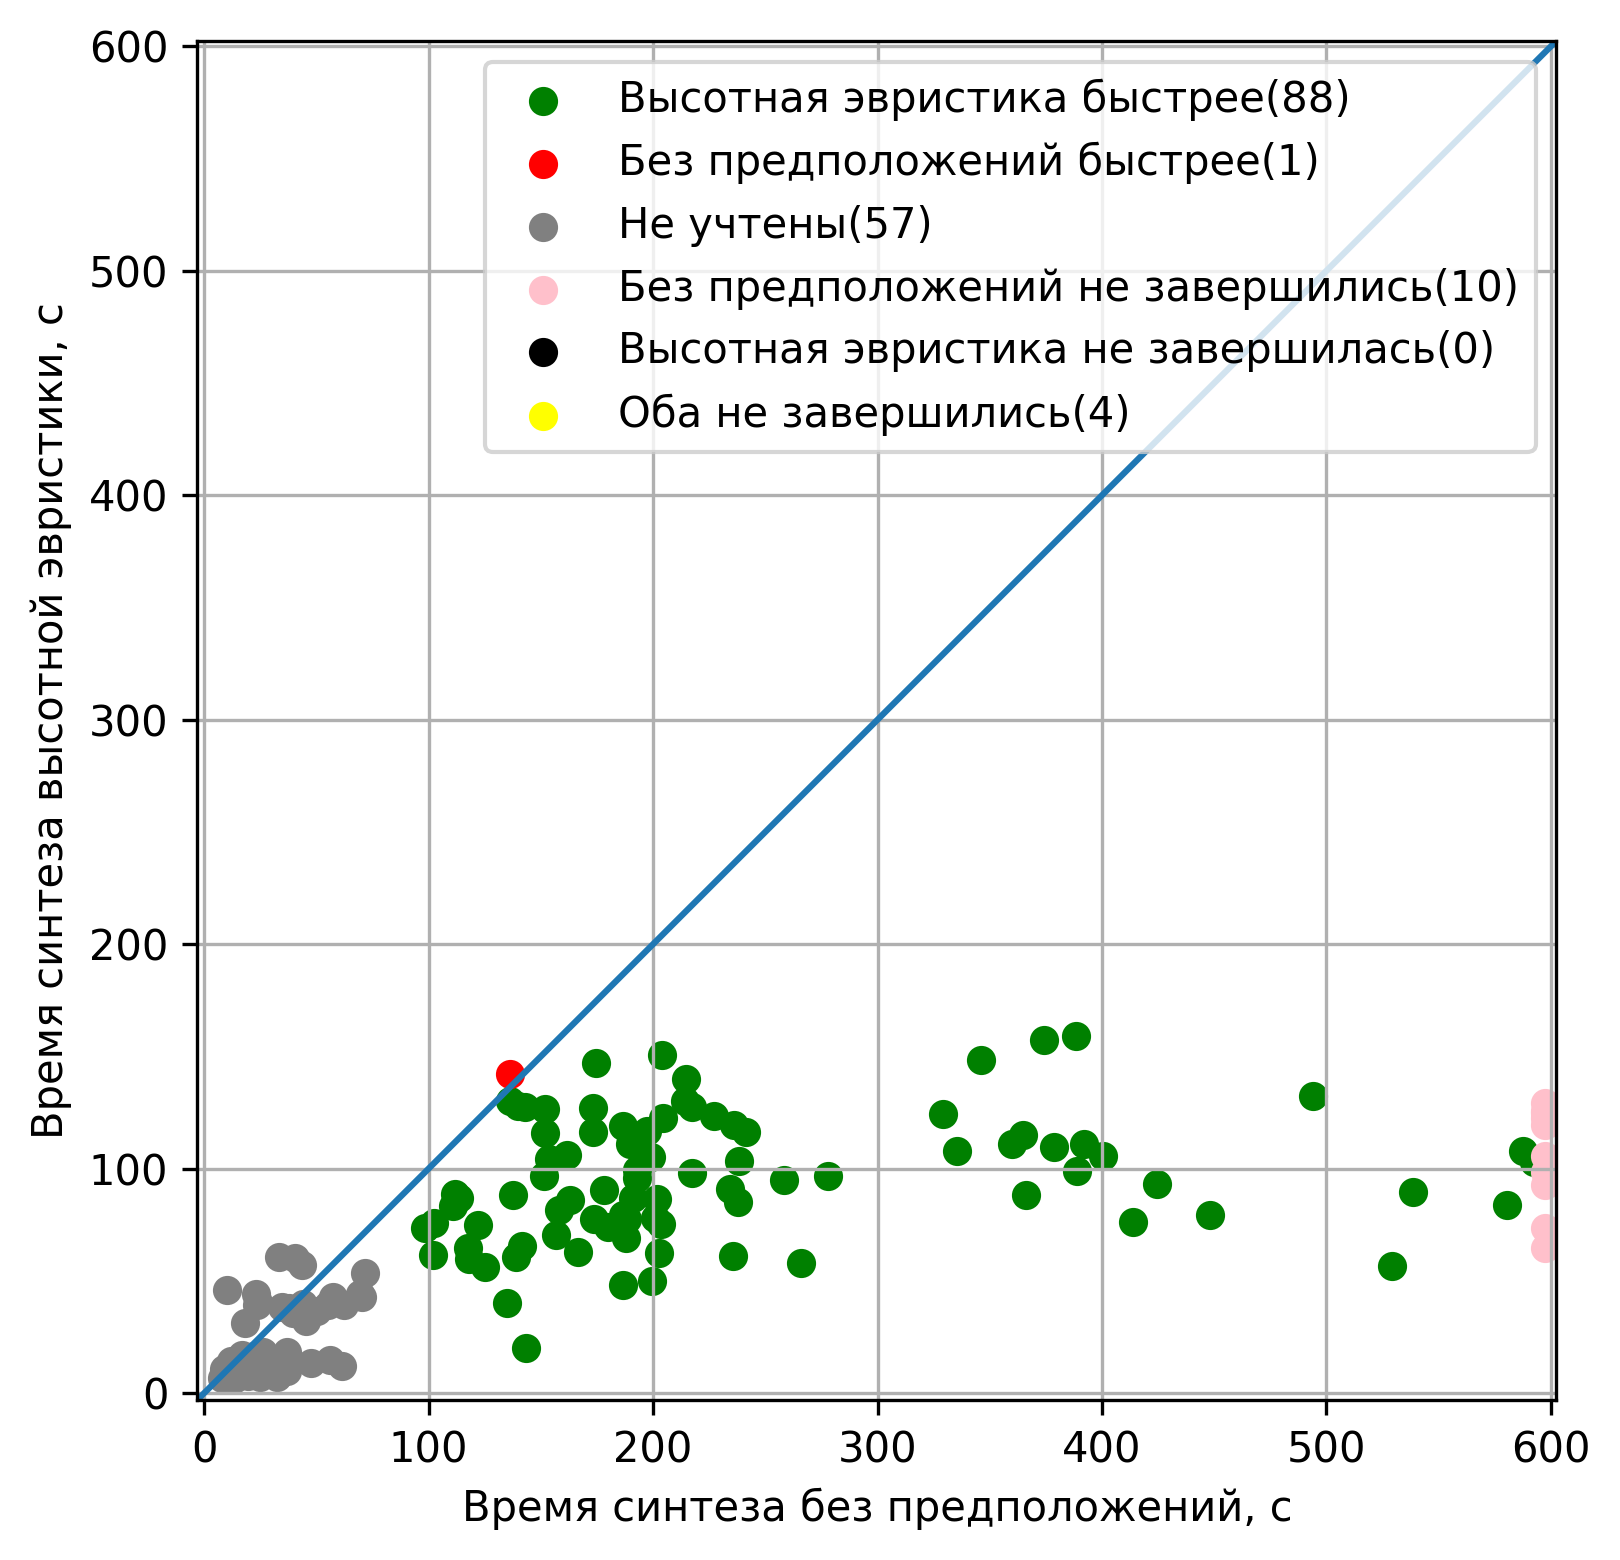

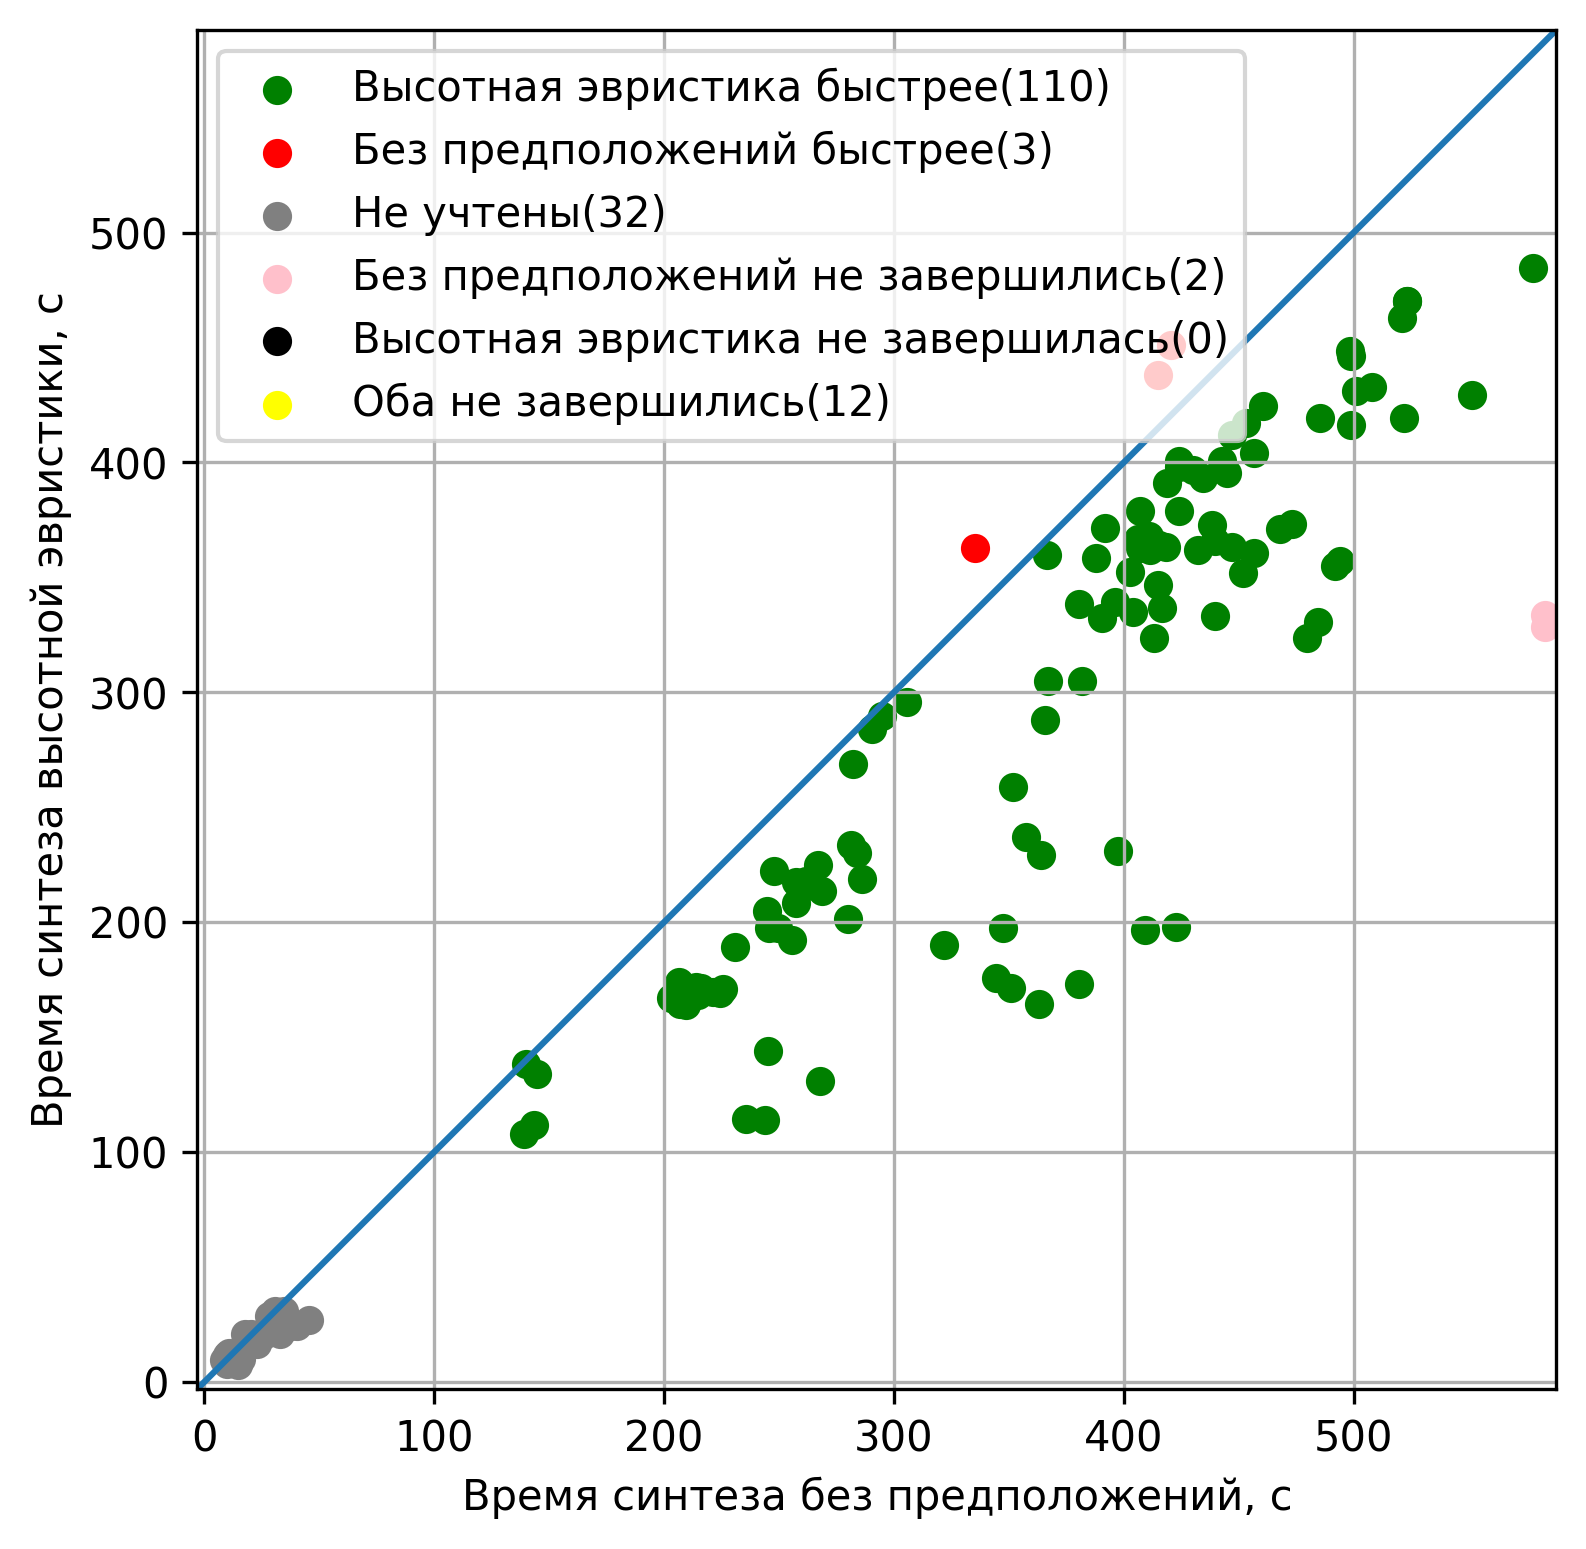

In [17]:
for i in range(18, 21):
    plt.figure(figsize=(8,6), dpi= 300)

    info = extract_info(height_stats, [(1, {i}), (4, {'height_total_duration', 'general_total_duration'})])
    keys = list({k[:4] for k in info})
    y = [info[k[:4] + ('height_total_duration',)] for k in keys]
    x = [info[k[:4] + ('general_total_duration'    ,)] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray, y_xnone, x_ynone, nones = split_coordinates(x, y)
    mx = max(x_green + y_green + x_red + y_red + x_blue + y_blue + x_gray + y_gray)
    print_csv(f'height-{i}', x_green, y_green, x_red, y_red, x_gray, y_gray, y_xnone, x_ynone, nones, "Эвристика 2")

    plt.scatter(x_green, y_green, color='green', label=f'Высотная эвристика быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    #plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
    plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    plt.scatter([mx + 5] * len(y_xnone), y_xnone, color='pink', label=f'Без предположений не завершились({len(y_xnone)})')
    plt.scatter(x_ynone, [mx + 5] * len(x_ynone), color='black', label=f'Высотная эвристика не завершилaсь({len(x_ynone)})')
    plt.scatter([], [], color='yellow', label=f'Оба не завершились({nones})')
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

    #plt.title(f'Время синтеза с длиной трассировки {i}', fontsize=20)
    plt.xlabel('Время синтеза без предположений, с')
    plt.ylabel('Время синтеза высотной эвристики, с')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()

In [221]:
for i in range(1, 11):
    continue
    
    plt.figure(figsize=(8,6), dpi= 300)
    
    info = extract_info(stats, [(0, {i}), (4, {'assumptions_total_duration', 'general_total_duration'})])
    keys = list({k[:4] for k in info if info[k[:4] + ('assumptions_total_duration',)] is not None and info[k[:4] + ('general_total_duration',)] is not None})
    y = [info[k[:4] + ('assumptions_total_duration',)] for k in keys]
    x = [info[k[:4] + ('general_total_duration'    ,)] for k in keys]
    x_green, y_green, x_red, y_red, x_blue, y_blue, x_gray, y_gray = split_coordinates(x, y)

    plt.scatter(x_green, y_green, color='green', label=f'С предположениями быстрее({len(x_green)})')
    plt.scatter(x_red, y_red, color='red', label=f'Без предположений быстрее({len(x_red)})')
    #plt.scatter(x_blue, y_blue, color='blue', label=f'Одинаково быстро({len(x_blue)})')
    plt.scatter(x_gray, y_gray, color='gray', label=f'Не учтены({len(x_gray)})')
    mx = max(max(x), max(y))
    plt.plot([-3, mx + 10], [-3, mx + 10])
    plt.axis([-3, mx + 10, -3, mx + 10], 'equal')

    plt.title(f'Время с числом трассировок {i}', fontsize=22)
    plt.xlabel('Время синтеза без предположений, с')
    plt.ylabel('Время синтеза с предположениями, с')
    plt.grid()
    plt.gca().set_aspect("equal")
    plt.legend()
    plt.show()